In [1]:
"""
Here I try to train my network on one set of detector signals
and test my network on the signals from a second detector.
"""

'\nHere I try to train my network on one set of detector signals\nand test my network on the signals from a second detector.\n'

In [2]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [3]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [4]:
print(len(tf.config.list_physical_devices('GPU')))

1


In [4]:
### Usable Files

direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Filtered/Processed/")

# direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector99/Filtered/")

file_list = list(direction.iterdir())

file_num = len(file_list)

num_test_files = 2
eighty = round(0.8*file_num)
twenty = file_num-eighty - num_test_files

list_of_file_ids_train = np.arange(eighty, dtype=int)

list_of_file_ids_val = np.arange(eighty,eighty+twenty-num_test_files, dtype=int)

list_of_file_ids_test =np.arange(file_num-num_test_files,file_num)



In [5]:
##### Functions to process the data

        ### Unnormalization of each signal individually
def Unnormalized(batch_signals):
        
        return batch_signals
        
        ### Normalization of each signal individually
def Normalized(batch_signals):

        for i in range(len(batch_signals)):
            batch_signals[i] = batch_signals[i]/np.max(batch_signals[i])
            
        return batch_signals
            
        
        ### Normalization of the entire value by one common denominator      
def Denominator(batch_signals):  
    
        denominator = 3953.48
        batch_signals = batch_signals/denominator
        
        return batch_signals


##### Class

class TrainDataset(tf.data.Dataset):

    def _generator(file_id):  
#         print(f'Using Train Class')
        if(file_id == 0):
#             print("reshuffling")
            np.random.shuffle(list_of_file_ids_train)             

        i_file = list_of_file_ids_train[file_id]

#         print(f'file_id: {file_id}, i_file: {i_file}')
#         print()
        signal_filename = direction/f'{i_file+1}.h5'

        
         # Load the labels and signals from the files
        df = pd.read_hdf(signal_filename,key=None)  
        
        labels1 = df.iloc[:,9].values
        labels2 = df['ToF'].values
        labels = labels1+labels2
        
        signals = df[df.columns[10:-2]].values
        
        
        # Determine how many batches can be made from this file
        num_batches = len(signals) // batch_size

        # Shuffle the signals within the file
        signal_indices = np.arange(len(signals))
        np.random.shuffle(signal_indices)        
        
        # Loop through each batch in the file
        for batch_idx in range(num_batches):
            # Get the signals and labels for this batch
            batch_signal_indices = signal_indices[batch_idx*batch_size:(batch_idx+1)*batch_size]      
 
            batch_signals = signals[batch_signal_indices]
            
            batch_signals = Processing[process](batch_signals)
                
            batch_signals = batch_signals[:,:,np.newaxis] # Can also be done with signals = signals[:,:,np.newaxis]
            batch_labels = labels[batch_signal_indices]

            # Yield the signals and labels as a tuple
            yield batch_signals, batch_labels 
             
    def __new__(cls, file_id):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float64, tf.dtypes.float64),
            output_shapes=((batch_size, 1998,1), (batch_size, )),
            args=(file_id,)
        )
    
class ValDataset(tf.data.Dataset):

    def _generator(file_id):  
#         print(f'Using Val Class')
        i_file = list_of_file_ids_val[file_id]
    
        signal_filename = direction/f'{i_file+1}.h5'

         # Load the labels and signals from the files
        df = pd.read_hdf(signal_filename,key=None)    
        
        labels1 = df.iloc[:,9].values
        labels2 = df['ToF'].values
        labels = labels1+labels2
        
        signals = df[df.columns[10:-2]].values
        
        
        # Determine how many batches can be made from this file
        num_batches = len(signals) // batch_size

        # Shuffle the signals within the file
        signal_indices = np.arange(len(signals))
        np.random.shuffle(signal_indices)        
        
        # Loop through each batch in the file
        for batch_idx in range(num_batches):
            # Get the signals and labels for this batch
            batch_signal_indices = signal_indices[batch_idx*batch_size:(batch_idx+1)*batch_size]      
 
            batch_signals = signals[batch_signal_indices]
            
            batch_signals = Processing[process](batch_signals)
                
            batch_signals = batch_signals[:,:,np.newaxis] # Can also be done with signals = signals[:,:,np.newaxis]
            batch_labels = labels[batch_signal_indices]

            # Yield the signals and labels as a tuple
            yield batch_signals, batch_labels
             
    def __new__(cls, file_id):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float64, tf.dtypes.float64),
            output_shapes=((batch_size, 1998,1), (batch_size, )),
            args=(file_id,)
        )

In [6]:
model = keras.models.Sequential()
model.add(Conv1D(filters=16, kernel_size=5,activation='relu', input_shape=(1998, 1)))
model.add(Conv1D(filters=8, kernel_size=5,dilation_rate=2,activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=5,dilation_rate=2,activation='relu'))
model.add(Conv1D(filters=4, kernel_size=5,strides=2,activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=3,strides=2))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1994, 16)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1986, 8)           648       
_________________________________________________________________
batch_normalization (BatchNo (None, 1986, 8)           32        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1978, 4)           164       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 987, 4)            84        
_________________________________________________________________
batch_normalization_1 (Batch (None, 987, 4)            16        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 493, 4)            5

In [8]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, BatchNormalization, Flatten, Dense, MaxPooling1D, Add

# model = Sequential()
# model.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(1998, 1)))
# model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=5, dilation_rate=2, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=5, dilation_rate=2, activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=64, kernel_size=5, dilation_rate=2, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=5, dilation_rate=2, activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=128, kernel_size=5, dilation_rate=2, activation='relu'))
# model.add(Conv1D(filters=128, kernel_size=5, dilation_rate=2, activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1))

# print(model.summary())

In [9]:
# model = tf.keras.models.Sequential()

# reg_factor = 0.01

# # Add the CNN layers with L1L2 regularization
# model.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(2000, 1), kernel_regularizer=L1L2(l1=reg_factor, l2=reg_factor)))
# model.add(Conv1D(filters=8, kernel_size=5, dilation_rate=2, activation='relu', kernel_regularizer=L1L2(l1=reg_factor, l2=reg_factor)))
# model.add(Conv1D(filters=4, kernel_size=5, dilation_rate=2, activation='relu', kernel_regularizer=L1L2(l1=reg_factor, l2=reg_factor)))
# model.add(Conv1D(filters=4, kernel_size=5, strides=2, activation='relu', kernel_regularizer=L1L2(l1=reg_factor, l2=reg_factor)))
# model.add(Conv1D(filters=4, kernel_size=3, strides=2, kernel_regularizer=L1L2(l1=reg_factor, l2=reg_factor)))

# # Flatten the output
# model.add(Flatten())

# # Add the remaining FNN layers without regularization
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1))

# print(model.summary())

In [7]:
# Pre-processing options
Processing = [Unnormalized,Normalized,Denominator]
process = 1

# Loss Function
loss_function = ['mean_absolute_error','mean_squared_error']
lf = 1

# Training Variables
batch_size = 32
num_epochs = 30

steps_per_epoch = eighty*5000 // batch_size

initial_lr = 1e-03
final_lr = 1e-06

# initial_lr = 1e-03
# final_lr = 1e-03

def step_decay(epoch):
    lrate = initial_lr * (final_lr/initial_lr)**(epoch/num_epochs)

    print(f'Current Learning rate: {lrate}')
    return lrate

# Compile the model
model.compile(loss=loss_function[lf], optimizer = keras.optimizers.Adam(initial_lr), metrics=['mean_absolute_error','mean_squared_error'])

# Configuring training dataset
dataset_train = tf.data.Dataset.range(eighty).interleave(
        TrainDataset,
        cycle_length=2,
        num_parallel_calls=2,
        deterministic=True).repeat().prefetch(1)



# Configuring training dataset
dataset_val = tf.data.Dataset.range(twenty-num_test_files).interleave(
        ValDataset,
        cycle_length=2,
        num_parallel_calls=2,
        deterministic=True).prefetch(1)


# Callback Functions
LRS = tf.keras.callbacks.LearningRateScheduler(step_decay)

ES = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True,verbose=1)

CSV = tf.keras.callbacks.CSVLogger("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Log.csv",
                                separator=",", append=True)

MC_path = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/model_checkpoint.h5")


MC = ModelCheckpoint(
    filepath=MC_path,  # Filepath to save the model weights
    monitor='val_loss',  # Quantity to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model based on the monitored quantity
    save_weights_only=True  # Save only the model weights, not the entire model
)

callbacks = [MC,LRS,CSV]




Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [11]:
history = model.fit(x=dataset_train, validation_data = dataset_val, steps_per_epoch=steps_per_epoch, epochs=num_epochs,callbacks=callbacks)

Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 64s 9ms/step - loss: 1991.6282 - mean_absolute_error: 5.3860 - mean_squared_error: 1991.6282 - val_loss: 1.4607 - val_mean_absolute_error: 1.1489 - val_mean_squared_error: 1.4607
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 35s 7ms/step - loss: 0.2133 - mean_absolute_error: 0.3481 - mean_squared_error: 0.2133 - val_loss: 580.0555 - val_mean_absolute_error: 24.0825 - val_mean_squared_error: 580.0555
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 39s 8ms/step - loss: 0.1689 - mean_absolute_error: 0.3236 - mean_squared_error: 0.1689 - val_loss: 0.1022 - val_mean_absolute_error: 0.2705 - val_mean_squared_error: 0.1022
Epoch 4/30
Current Learning rate: 0.0005011872336272722
5000/5000 [==============================] - 36s 7ms/step - loss: 0.1243 - mean_absolute_error: 0.2805 - mean_squared_error: 0.

Train Final: 0.02199062705039978
Val Final: 0.01944848895072937


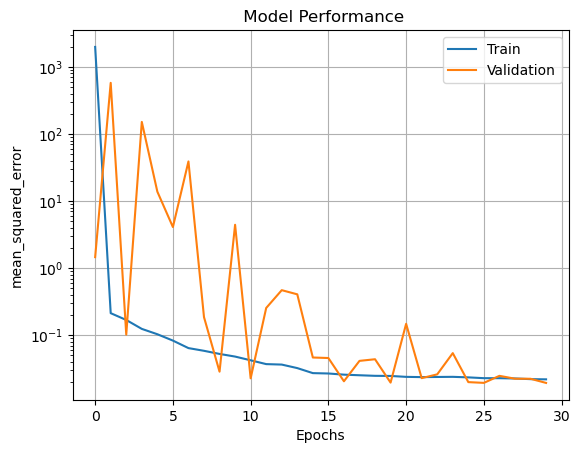

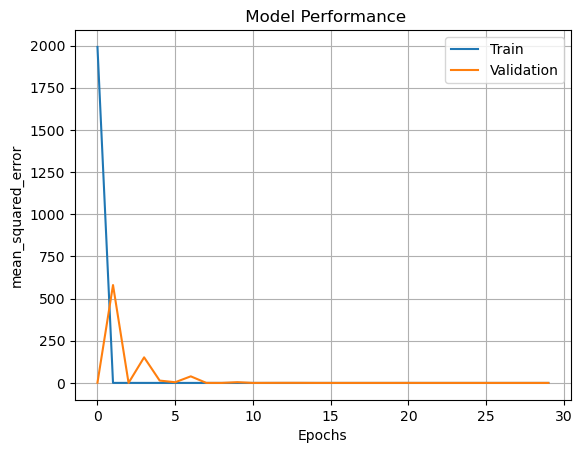

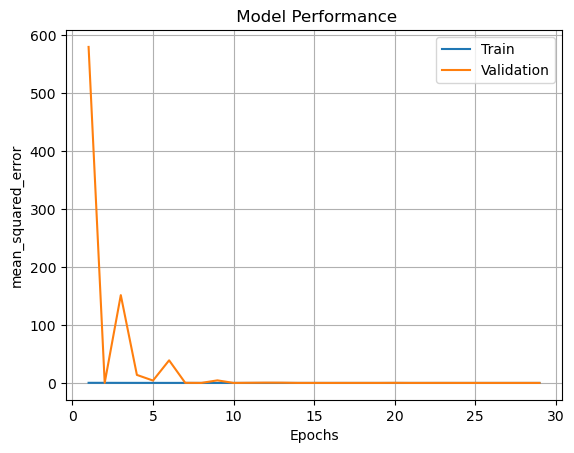

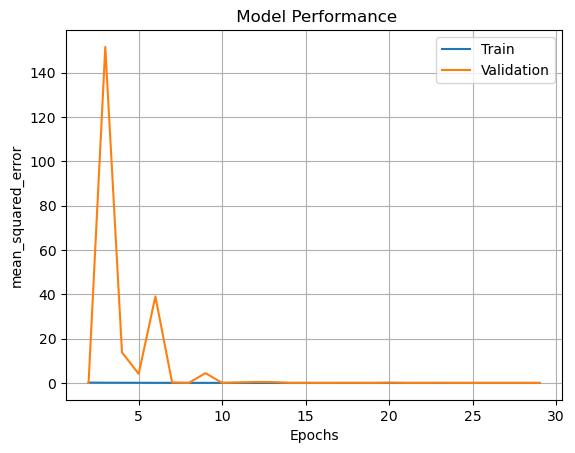

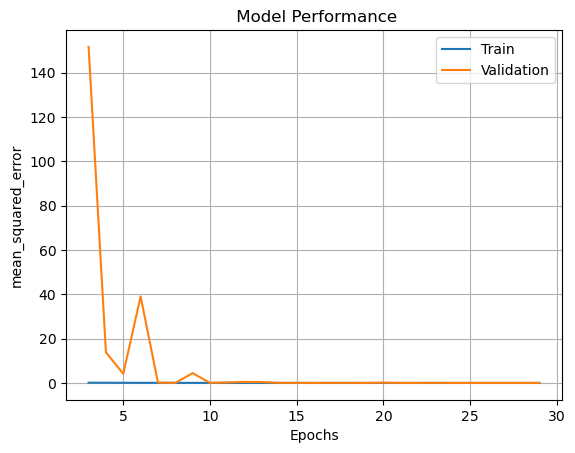

In [13]:
##### All Analysis Tools:::

# Loss/Val vs Epochs
loss = history.history['loss']
val = history.history['val_loss']

x = np.arange(1,len(loss))

# print(f'Training: {loss} \n')
# print(f'Validation: {val}')

print(f'Train Final: {loss[-1]}')
print(f'Val Final: {val[-1]}')

# Full Training
plt.plot(loss,label='Train')
plt.title(f' Model Performance')
plt.plot(val,label='Validation')
plt.ylabel(f'{loss_function[lf]}')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# Full Training
plt.plot(loss,label='Train')
plt.title(f' Model Performance')
plt.plot(val,label='Validation')
plt.ylabel(f'{loss_function[lf]}')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# Full training without first epoch
plt.plot(x,loss[1:],label='Train')
plt.plot(x,val[1:],label='Validation')
plt.title(f' Model Performance')
plt.ylabel(f'{loss_function[lf]}')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# Full training without first two epochs
plt.plot(x[1:],loss[2:],label='Train')
plt.plot(x[1:],val[2:],label='Validation')
plt.title(f' Model Performance')
plt.ylabel(f'{loss_function[lf]}')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# Full training without first three epochs
plt.plot(x[2:],loss[3:],label='Train')
plt.plot(x[2:],val[3:],label='Validation')
plt.title(f' Model Performance')
plt.ylabel(f'{loss_function[lf]}')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

In [8]:
model.load_weights(MC_path)

In [9]:
avg_loss = []


for i in list_of_file_ids_test:
    df = pd.read_hdf(file_list[i],key=None)   

    labels1 = df.iloc[:,9].values
    labels2 = df['ToF'].values
    labels = labels1+labels2

    signals = df[df.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:,:,np.newaxis]

    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted) # getting rid of extra dimension
    true = labels
    
    test_loss = np.subtract(predicted,true)
    
    avg_test_loss = np.mean(np.abs(test_loss))
    print(avg_test_loss)
    avg_loss.append(avg_test_loss)
    
print(f'Mean Absolute Error: {np.mean(avg_loss)}')

0.1050814724572446
0.10499174972236562
Mean Absolute Error: 0.10503661108980511


In [10]:
avg_loss = []

for i in list_of_file_ids_test:
    df = pd.read_hdf(file_list[i], key=None)
    
    labels1 = df.iloc[:, 9].values
    labels2 = df['ToF'].values
    labels = labels1 + labels2
    
    signals = df[df.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]
    
    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)  # getting rid of extra dimension
    true = labels
    
    test_loss = np.subtract(predicted, true)
    
    # Calculate mean squared error (MSE)
    mse = np.mean(np.square(test_loss))
    print("Mean Squared Error:", mse)
    
    avg_loss.append(mse)
    
print(f'Mean Squared Error: {np.mean(avg_loss)}')

Mean Squared Error: 0.01930440629671601
Mean Squared Error: 0.019245613870495094
Mean Squared Error: 0.01927501008360555


In [11]:
# direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Filtered/Processed/")

direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector99/Filtered/")


file_list = list(direction.iterdir())

file_num = len(file_list)


df = pd.read_hdf(file_list[0],key=None)

avg_loss = []

for file in file_list:
    df = pd.read_hdf(file,key=None)   

    labels1 = df.iloc[:,9].values
    labels2 = df['ToF'].values
    labels = labels1+labels2

    signals = df[df.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:,:,np.newaxis]

    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted) # getting rid of extra dimension
    true = labels
    
    test_loss = np.subtract(predicted, true)
    
    # Calculate mean squared error (MSE)
    mse = np.mean(np.square(test_loss))
    print("Mean Squared Error:", mse)
    
    avg_loss.append(mse)
    
print(f'Final Mean Squared Error: {np.mean(avg_loss)}')

Mean Squared Error: 12.90931423974509
Mean Squared Error: 12.894363372134713
Mean Squared Error: 12.890905939177173
Mean Squared Error: 12.897166690957487
Mean Squared Error: 12.873692214008212
Mean Squared Error: 12.90513724363863
Mean Squared Error: 12.907171347205994
Mean Squared Error: 12.89885522541458
Mean Squared Error: 12.888412283837695
Mean Squared Error: 12.86620201991991
Mean Squared Error: 12.905774794108225
Mean Squared Error: 12.888076245973872
Mean Squared Error: 12.865423436539722
Mean Squared Error: 12.868407862258318
Mean Squared Error: 12.894236087874605
Mean Squared Error: 12.880690791804504
Mean Squared Error: 12.849188988616321
Mean Squared Error: 12.879704432069447
Mean Squared Error: 12.860256774033592
Mean Squared Error: 12.871974438128708
Mean Squared Error: 12.886321064318684
Mean Squared Error: 12.851707302063389
Mean Squared Error: 12.895840709107562
Mean Squared Error: 12.865636518611932
Mean Squared Error: 12.856125078406164
Mean Squared Error: 12.877055

In [12]:
direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector99/Filtered/")
file_list = list(direction.iterdir())
file_num = len(file_list)
file_list = file_list[:10]

df = pd.read_hdf(file_list[0], key=None)
avg_loss = []

for file in file_list:
    df = pd.read_hdf(file, key=None)

    labels1 = df.iloc[:, 9].values
    labels2 = df['ToF'].values
    labels = labels1 + labels2

    signals = df[df.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)  # getting rid of extra dimension
    true = labels

    test_loss = np.abs(predicted - true)

    # Calculate mean absolute error (MAE)
    mae = np.mean(test_loss)
    print("Mean Absolute Error:", mae)

    avg_loss.append(mae)

print(f'Final Mean Absolute Error: {np.mean(avg_loss)}')

Mean Absolute Error: 3.5832717872565056
Mean Absolute Error: 3.581376415017641
Mean Absolute Error: 3.580686936072452
Mean Absolute Error: 3.581563455778737
Mean Absolute Error: 3.5784086845774716
Mean Absolute Error: 3.582723973743275
Mean Absolute Error: 3.583181868177945
Mean Absolute Error: 3.5817332346894175
Mean Absolute Error: 3.5804836482658717
Mean Absolute Error: 3.577291521366305
Final Mean Absolute Error: 3.581072152494562


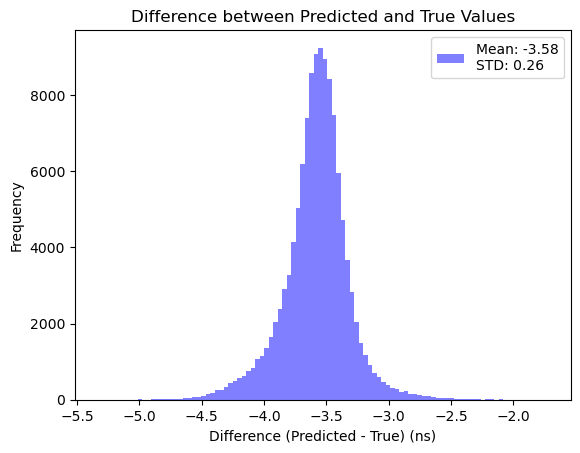

In [13]:
# Initialize variables for mean and standard deviation
mean = 0.0
std = 0.0
all_differences = []

# Iterate over each file and process the data
for file_id in file_list:
    # Read the data from the file
    df_test = pd.read_hdf(file_id, key=None)
    
    labels1 = df_test.iloc[:, 9].values
    labels2 = df_test['ToF'].values
    labels = labels1 + labels2

    signals = df_test[df_test.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)  # getting rid of extra dimension
    true = labels

    difference = predicted - true
    
    # Update mean and standard deviation
    mean += np.mean(difference)
    std += np.std(difference)
    
    # Append differences to a list
    all_differences.extend(difference)

# Calculate mean and standard deviation across all files
mean /= len(file_list)
std /= len(file_list)

# Generate the histogram
plt.hist(all_differences, bins=100, alpha=0.5, color='blue')

# Create legend text with mean and standard deviation
legend_text = f"Mean: {mean:.2f}\nSTD: {std:.2f}"

# Add legend with the mean and standard deviation
plt.legend([legend_text])

# Set plot title and labels
plt.title("Difference between Predicted and True Values")
plt.xlabel("Difference (Predicted - True) (ns)")
plt.ylabel("Frequency")

# Display the plot
plt.show()

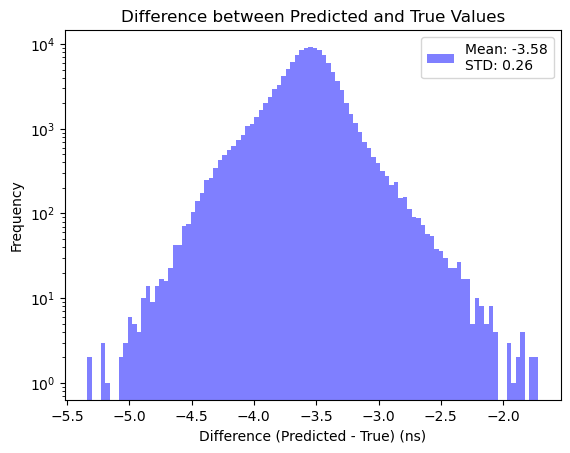

In [14]:
plt.hist(all_differences, bins=100, alpha=0.5, color='blue')

# Create legend text with mean and standard deviation
legend_text = f"Mean: {mean:.2f}\nSTD: {std:.2f}"

# Add legend with the mean and standard deviation
plt.legend([legend_text])

# Set plot title and labels
plt.title("Difference between Predicted and True Values")
plt.xlabel("Difference (Predicted - True) (ns)")
plt.ylabel("Frequency")
plt.yscale('log')

# Display the plot
plt.show()

In [15]:
direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector99/Filtered/")
file_list = list(direction.iterdir())

section_list = file_list[:10]

avg_loss = []


for i in range(len(section_list)):
    df = pd.read_hdf(section_list[i],key=None)   

    labels1 = df.iloc[:,9].values
    labels2 = df['ToF'].values
    labels = labels1+labels2

    signals = df[df.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:,:,np.newaxis]

    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted) # getting rid of extra dimension
    true = labels
    
    test_loss = np.subtract(predicted,true)
    
    avg_test_loss = np.mean(np.abs(test_loss))
    print(avg_test_loss)
    avg_loss.append(avg_test_loss)
    
print(f'Mean Absolute Error: {np.mean(avg_loss)}')

3.5832717872565056
3.581376415017641
3.580686936072452
3.581563455778737
3.5784086845774716
3.582723973743275
3.583181868177945
3.5817332346894175
3.5804836482658717
3.577291521366305
Mean Absolute Error: 3.581072152494562


In [16]:
avg_loss = []

for i in range(len(section_list)):
    df = pd.read_hdf(section_list[i],key=None)  
    
    labels1 = df.iloc[:, 9].values
    labels2 = df['ToF'].values
    labels = labels1 + labels2
    
    signals = df[df.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]
    
    # model.predict
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)  # getting rid of extra dimension
    true = labels
    
    test_loss = np.subtract(predicted, true)
    
    # Calculate mean squared error (MSE)
    mse = np.mean(np.square(test_loss))
    print("Mean Squared Error:", mse)
    
    avg_loss.append(mse)
    
print(f'Mean Squared Error: {np.mean(avg_loss)}')

Mean Squared Error: 12.90931423974509
Mean Squared Error: 12.894363372134713
Mean Squared Error: 12.890905939177173
Mean Squared Error: 12.897166690957487
Mean Squared Error: 12.873692214008212
Mean Squared Error: 12.90513724363863
Mean Squared Error: 12.907171347205994
Mean Squared Error: 12.89885522541458
Mean Squared Error: 12.888412283837695
Mean Squared Error: 12.86620201991991
Mean Squared Error: 12.89312205760395


Unique Mass: 100.0
Unique Energy: 107


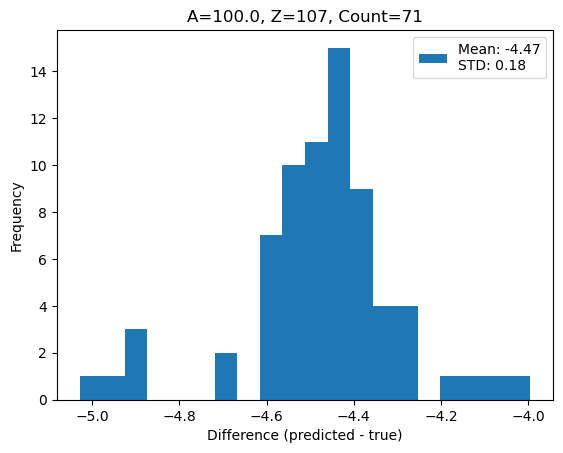

Unique Energy: 34


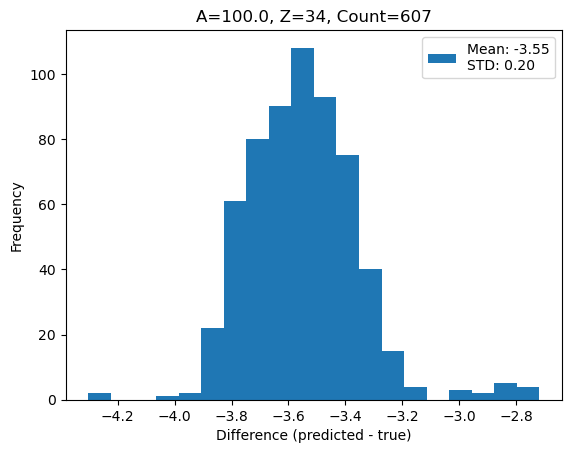

Unique Energy: 41


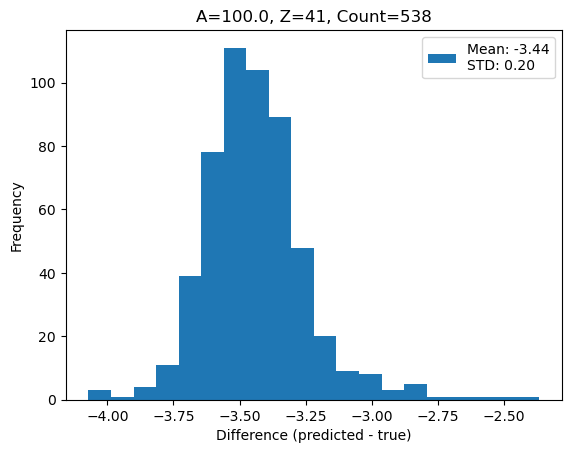

Unique Energy: 48


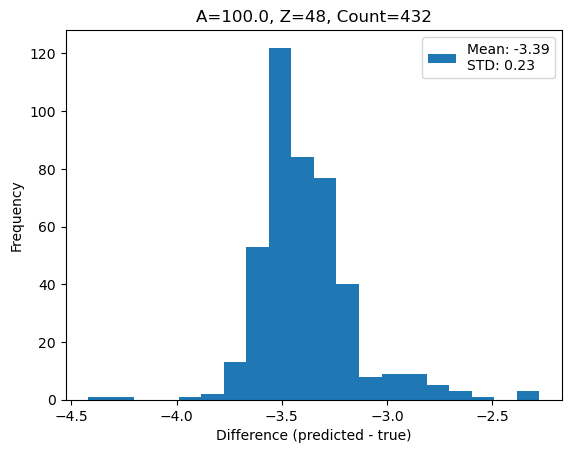

Unique Energy: 58


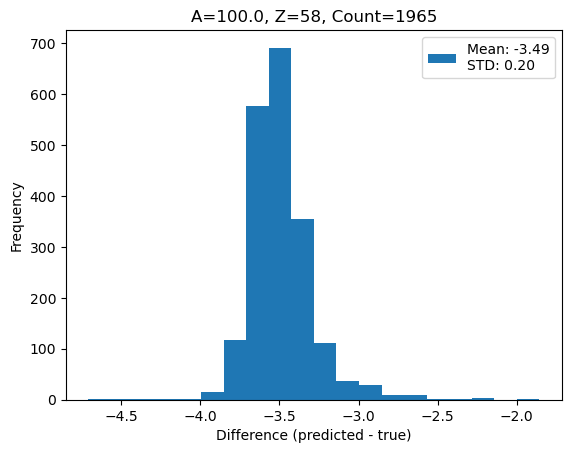

Unique Energy: 68


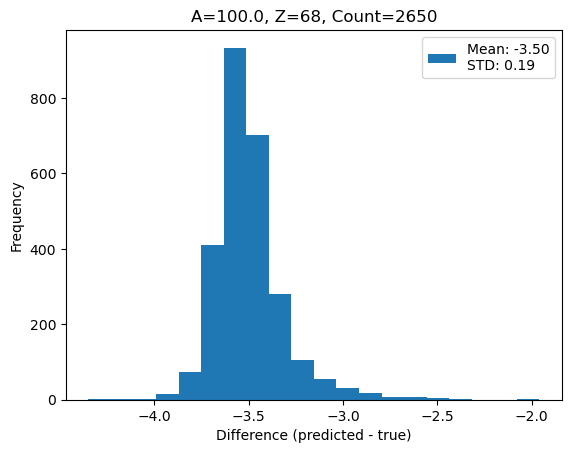

Unique Energy: 78


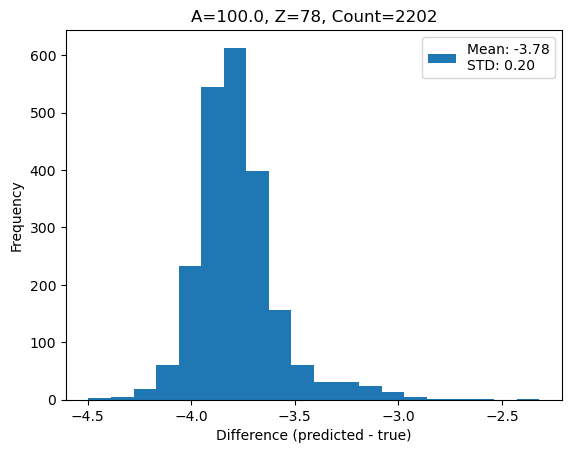

Unique Energy: 87


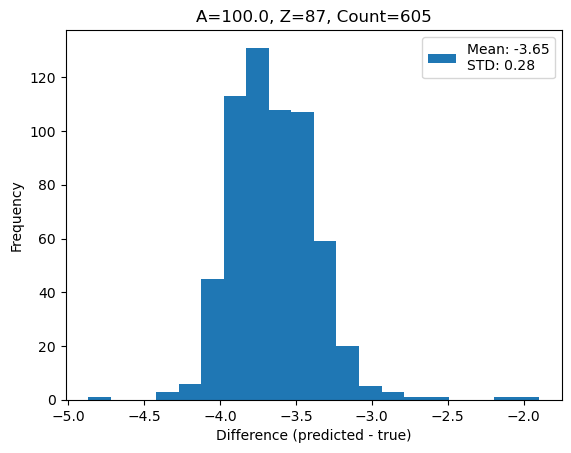

Unique Energy: 97


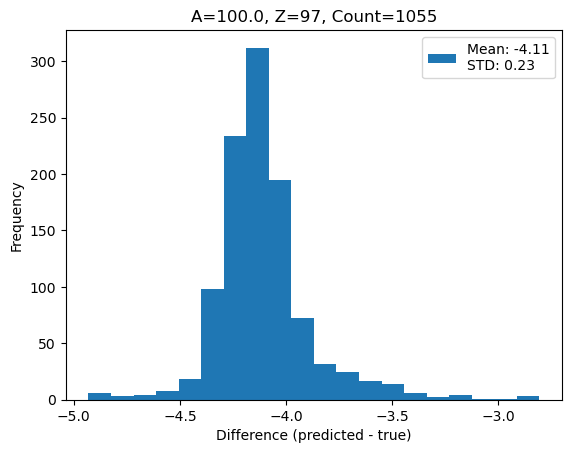

Unique Mass: 104.0
Unique Energy: 22


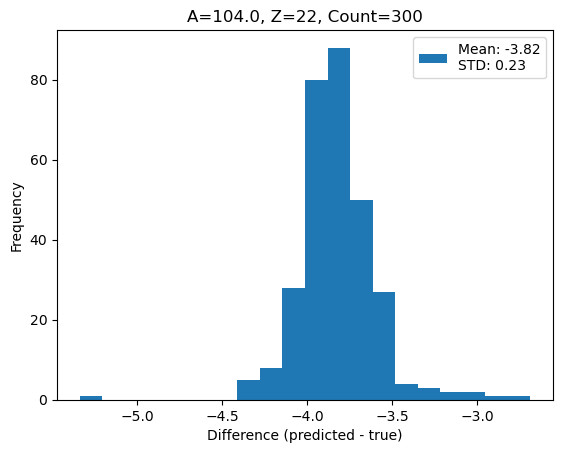

Unique Energy: 30


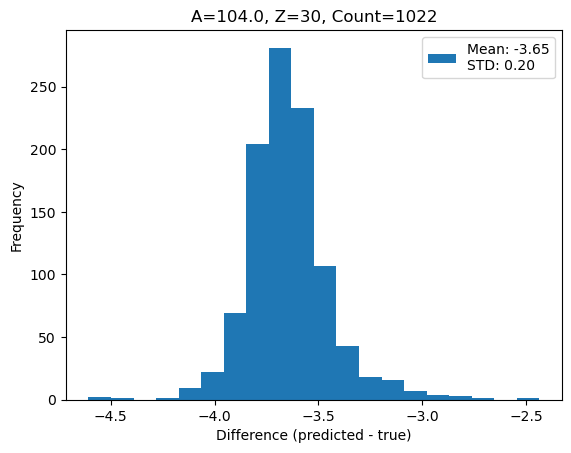

Unique Energy: 38


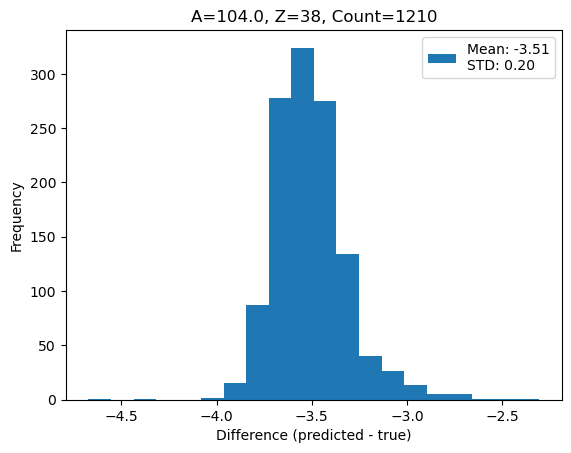

Unique Energy: 46


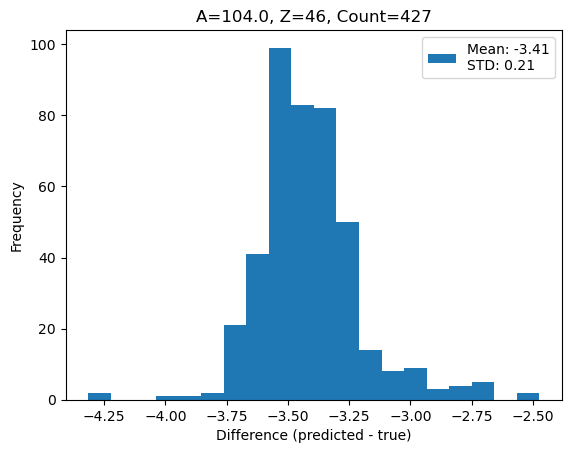

Unique Energy: 54


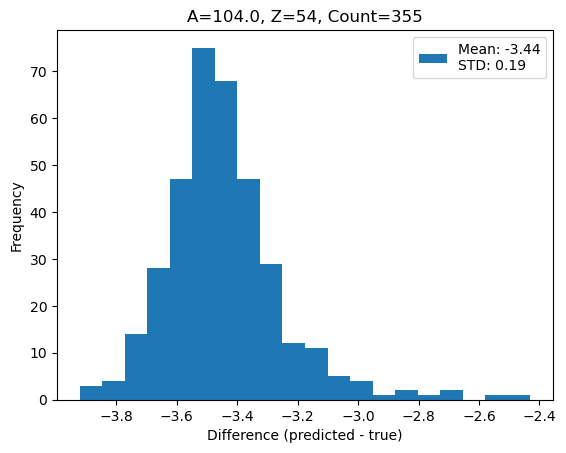

Unique Energy: 62


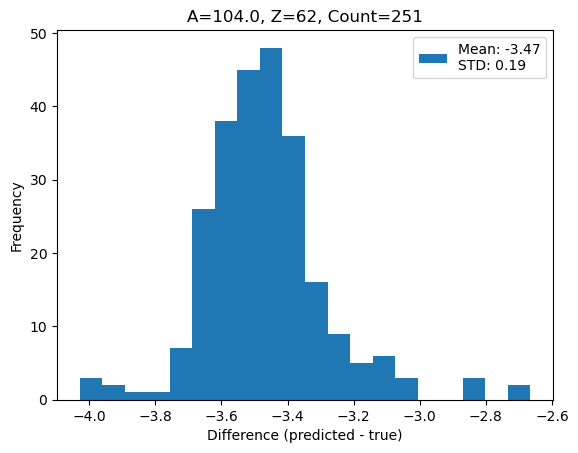

Unique Mass: 105.0
Unique Energy: 102


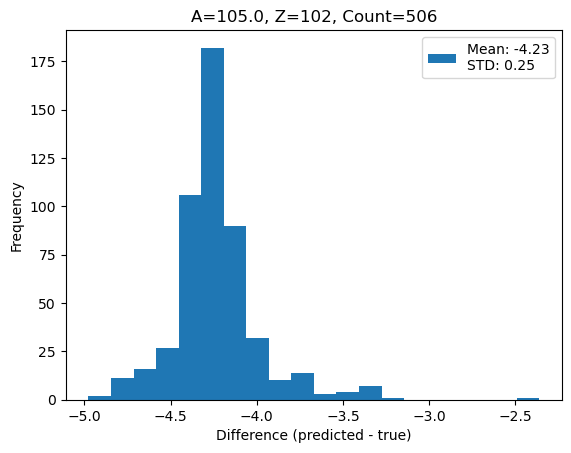

Unique Energy: 61


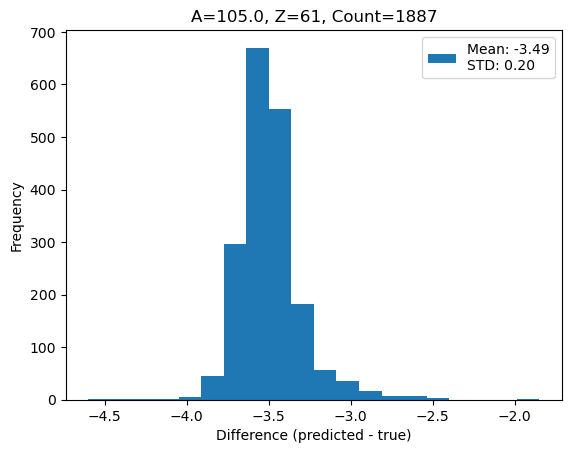

Unique Energy: 71


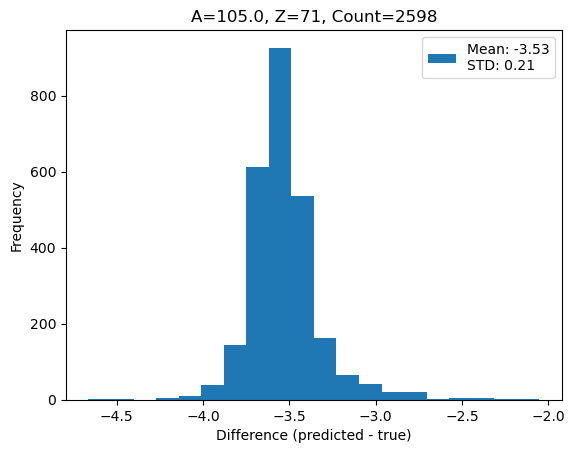

Unique Energy: 81


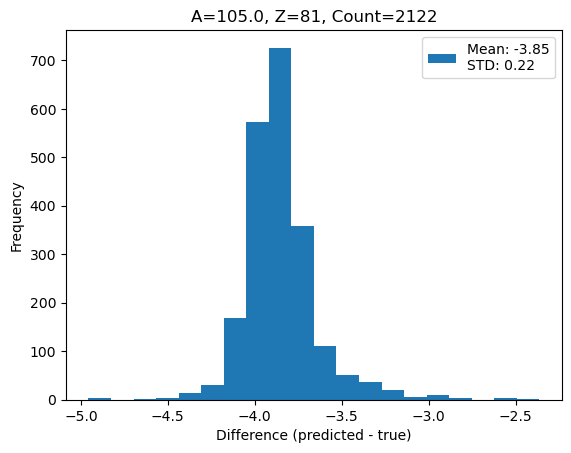

Unique Energy: 92


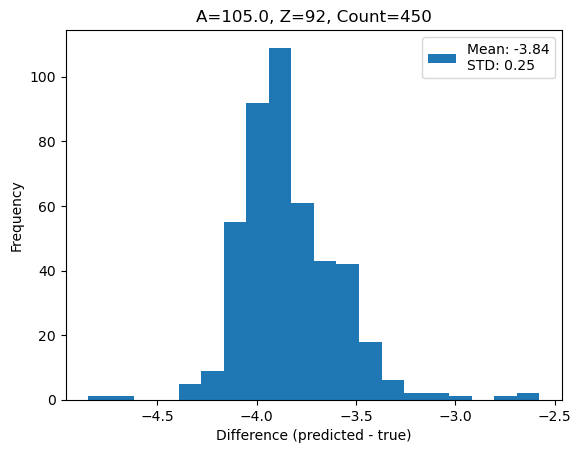

Unique Mass: 110.0
Unique Energy: 46


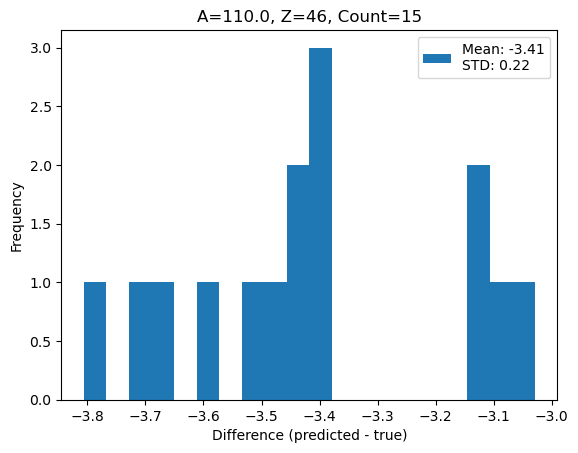

Unique Energy: 62


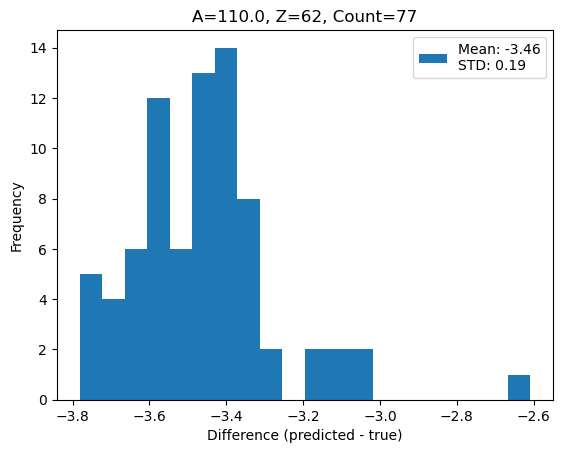

Unique Energy: 64


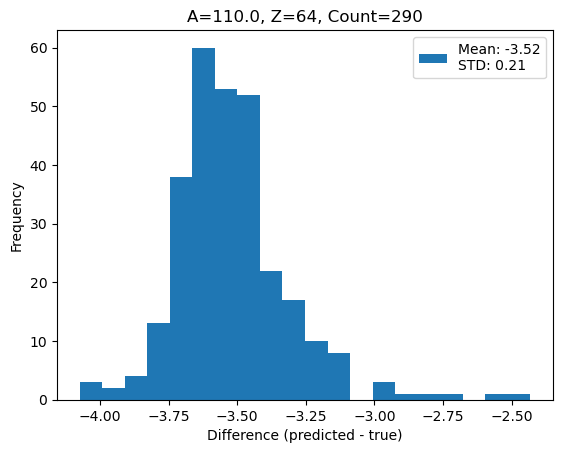

Unique Energy: 74


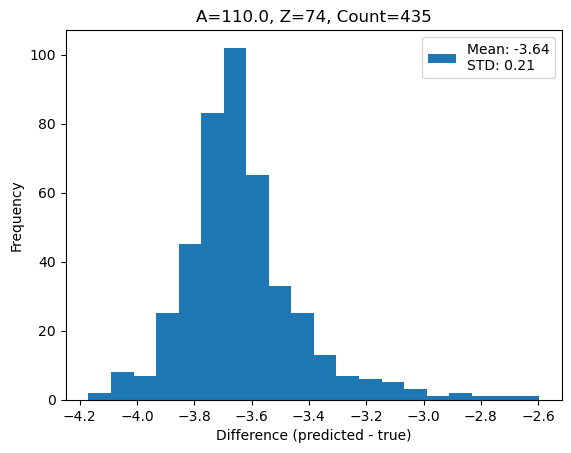

Unique Energy: 85


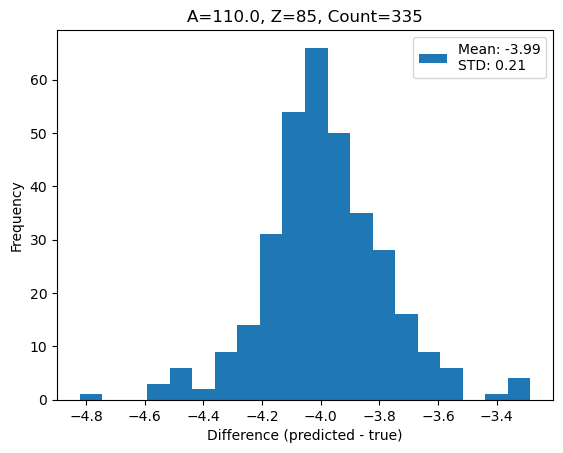

Unique Energy: 96


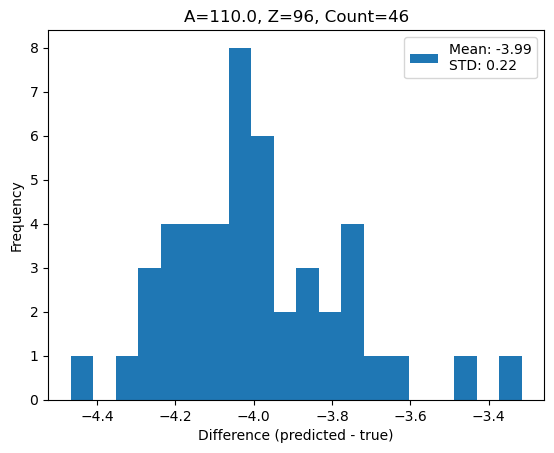

Unique Mass: 130.0
Unique Energy: 28


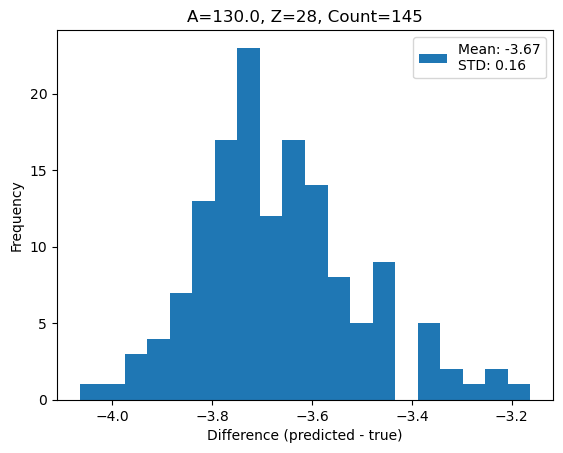

Unique Energy: 38


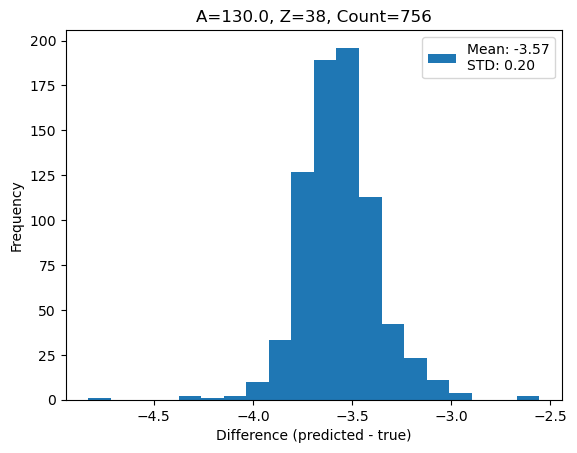

Unique Energy: 48


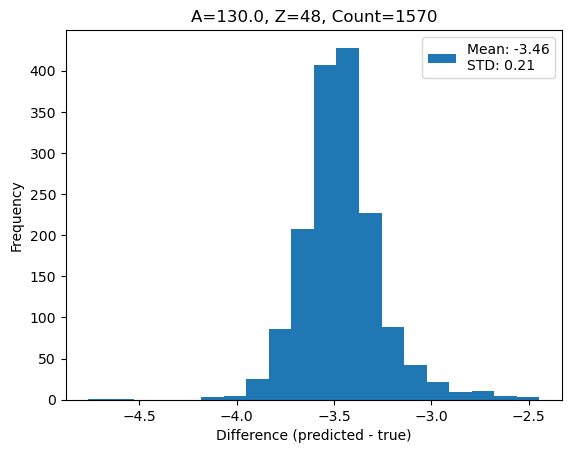

Unique Energy: 58


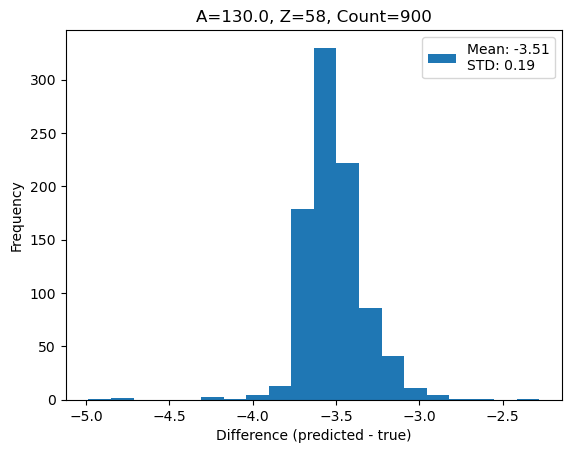

Unique Energy: 67


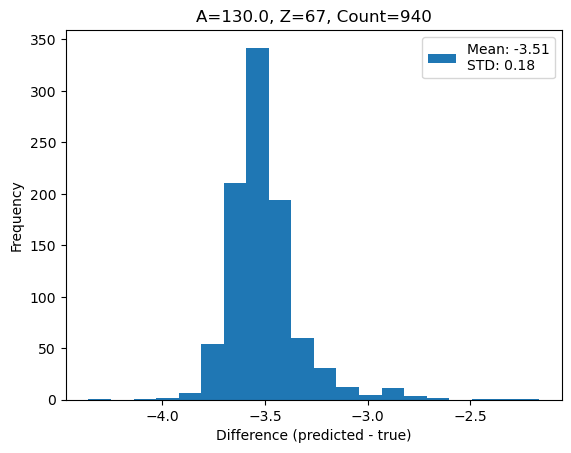

Unique Energy: 75


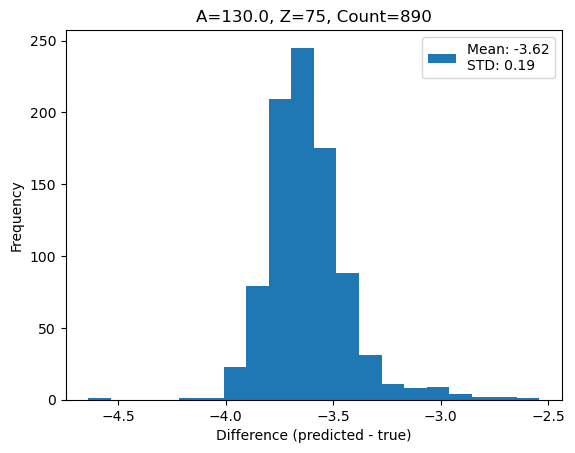

Unique Energy: 77


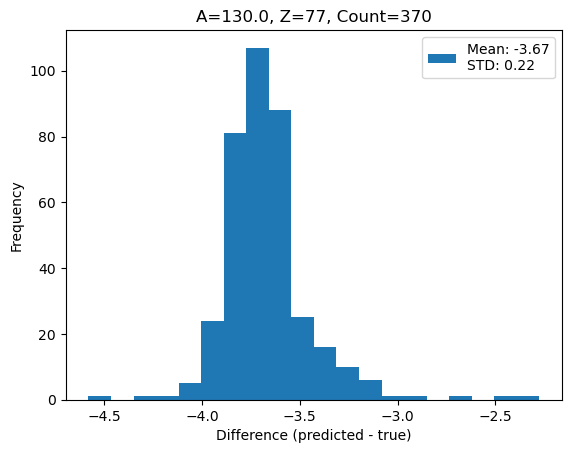

Unique Energy: 88


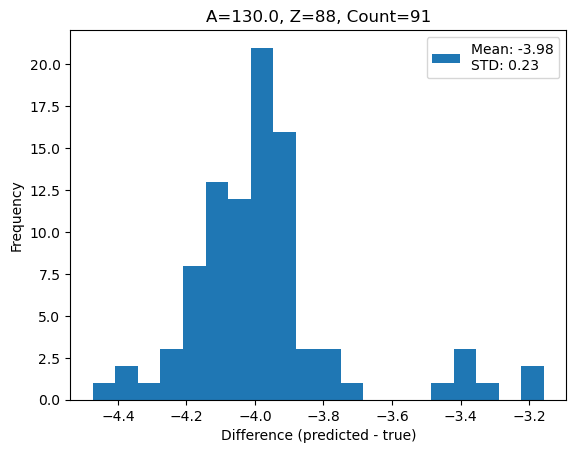

Unique Mass: 133.0
Unique Energy: 55


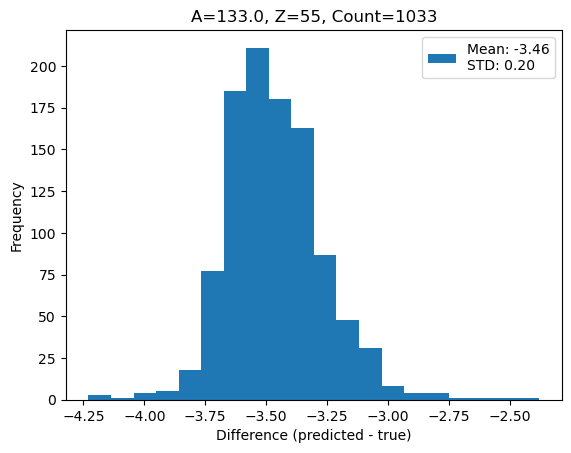

Unique Energy: 64


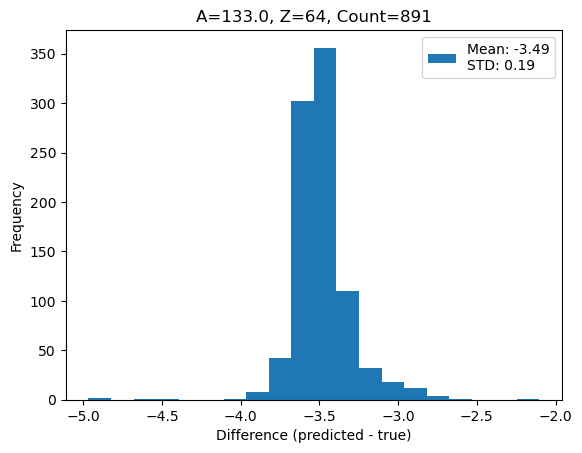

Unique Mass: 135.0
Unique Energy: 78


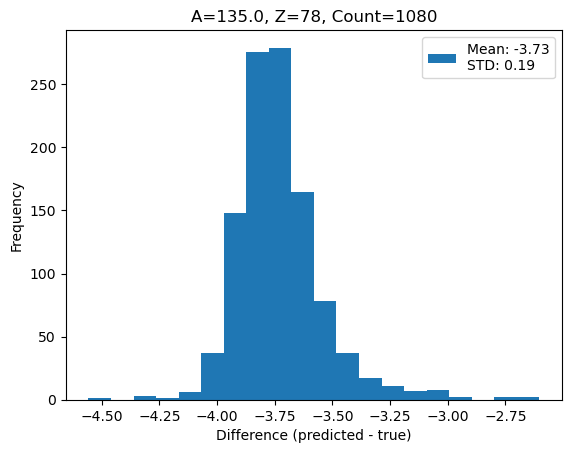

Unique Mass: 136.0
Unique Energy: 38


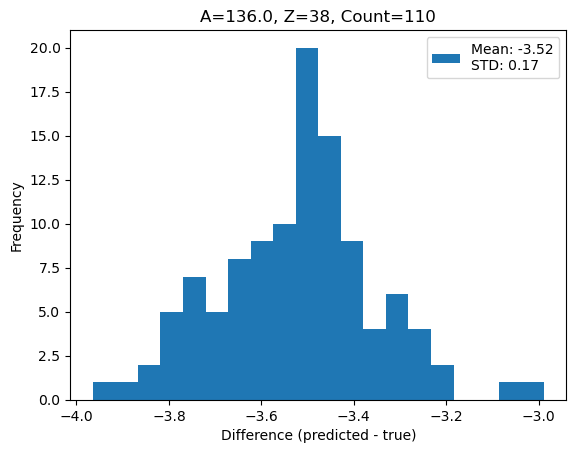

Unique Energy: 48


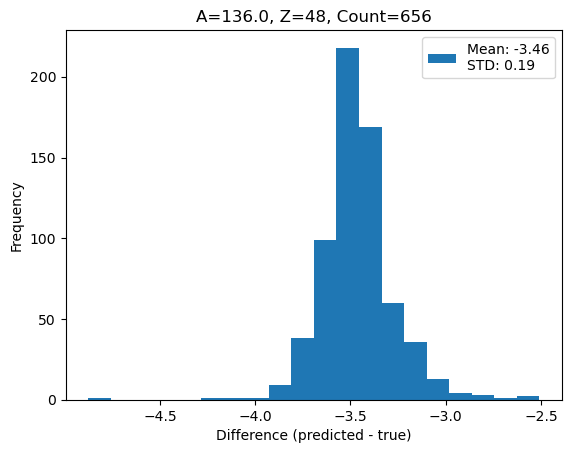

Unique Energy: 57


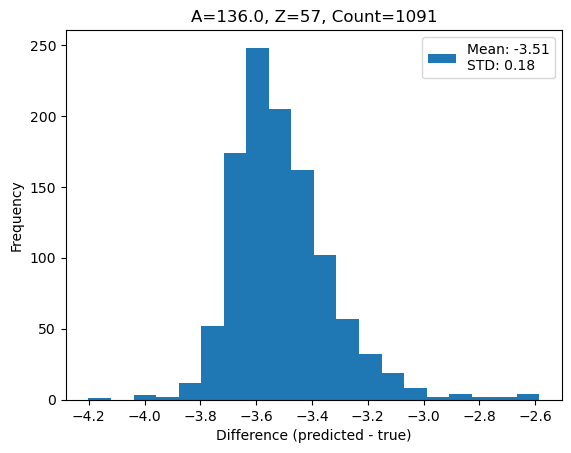

Unique Energy: 67


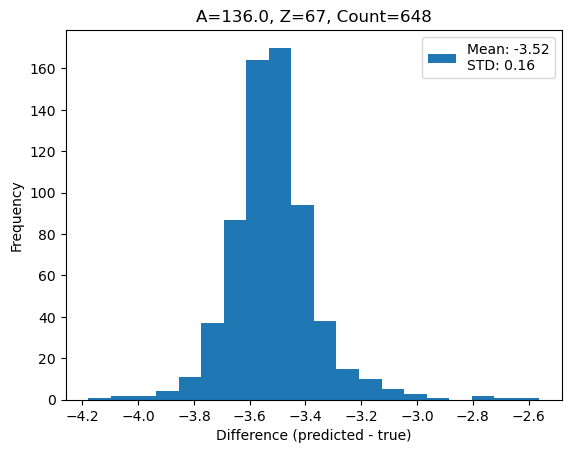

Unique Energy: 77


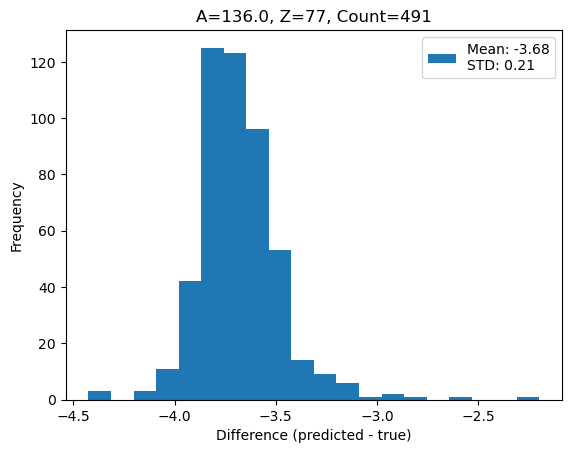

Unique Mass: 140.0
Unique Energy: 48


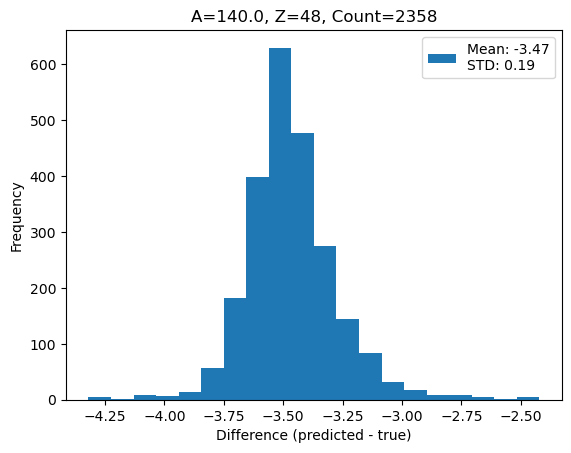

Unique Energy: 57


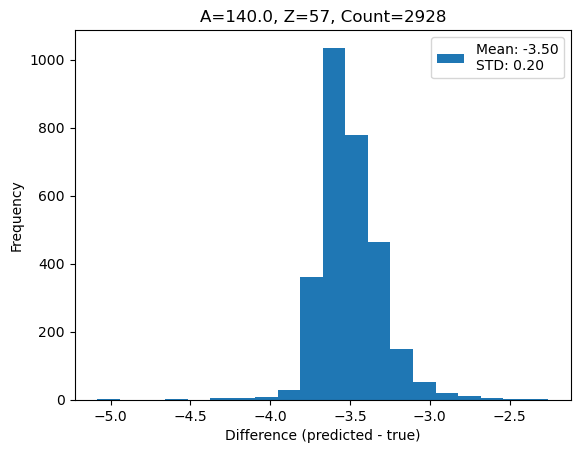

Unique Energy: 67


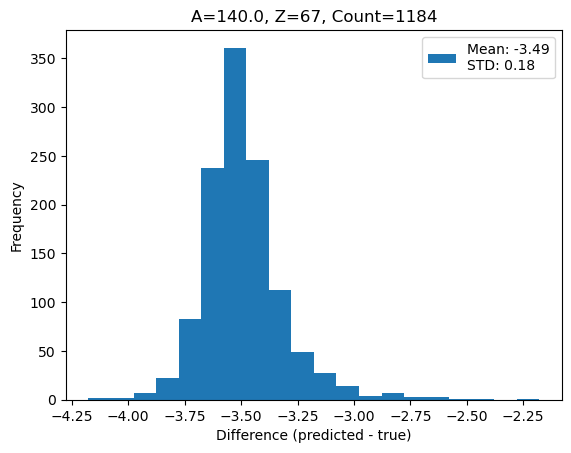

Unique Mass: 143.0
Unique Energy: 31


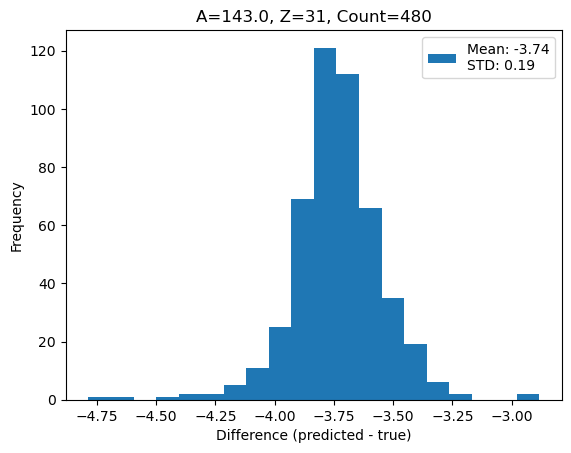

Unique Energy: 42


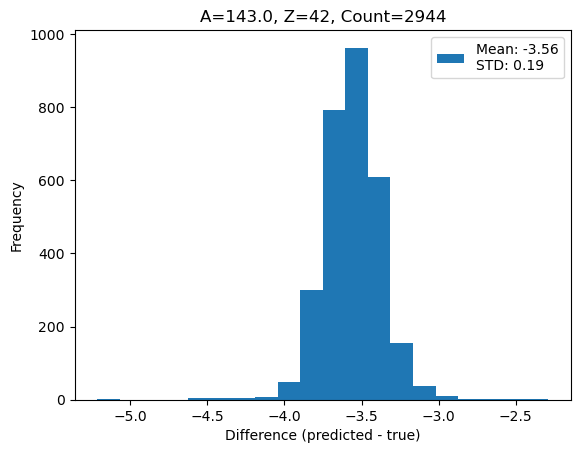

Unique Energy: 52


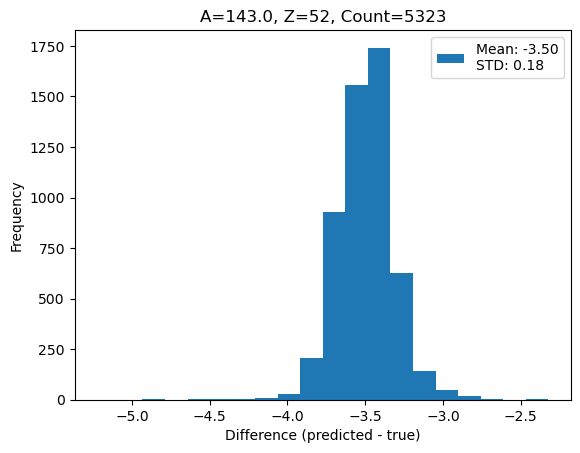

Unique Energy: 63


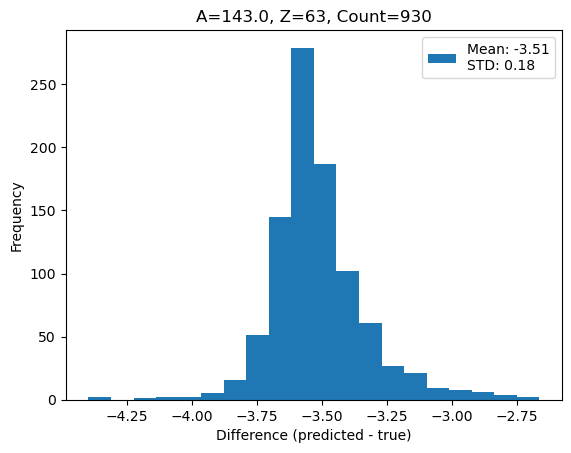

Unique Mass: 149.0
Unique Energy: 41


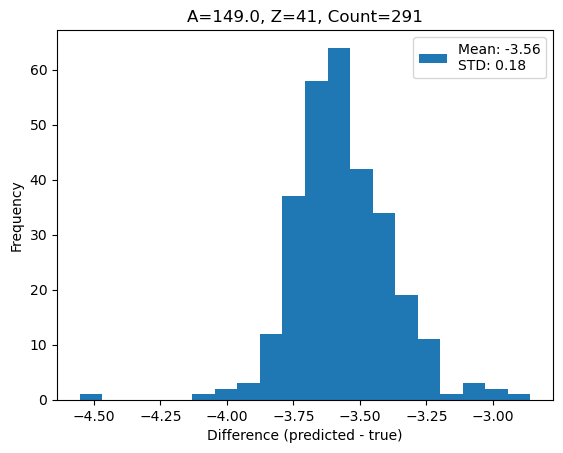

Unique Energy: 52


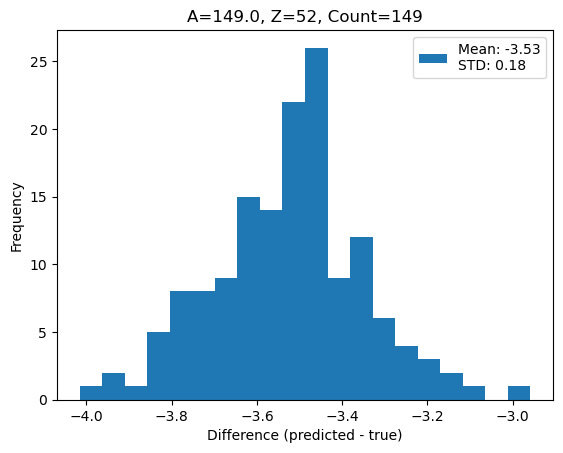

Unique Mass: 80.0
Unique Energy: 94


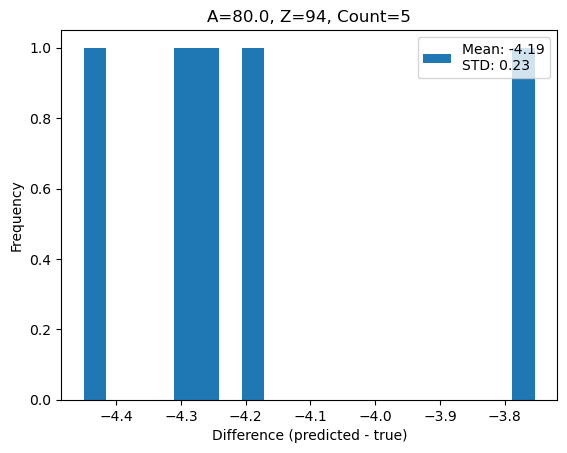

Unique Mass: 85.0
Unique Energy: 100


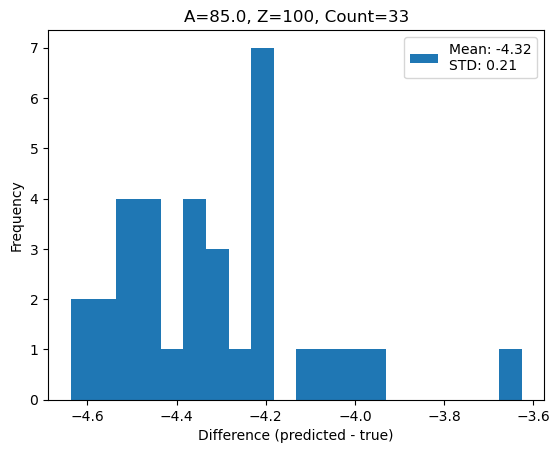

Unique Energy: 49


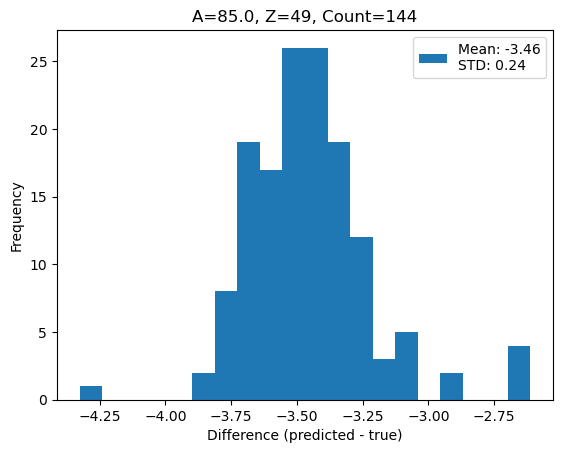

Unique Energy: 57


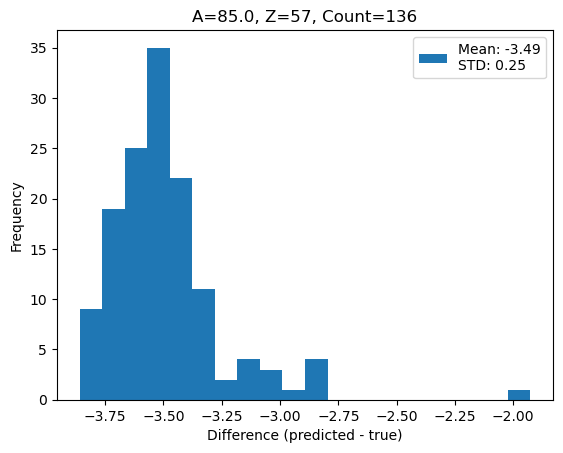

Unique Energy: 66


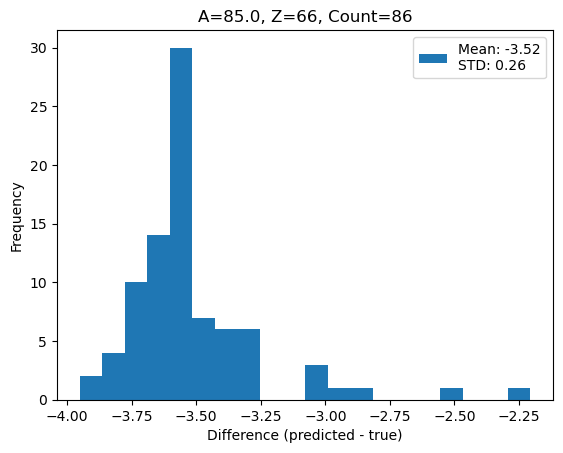

Unique Energy: 74


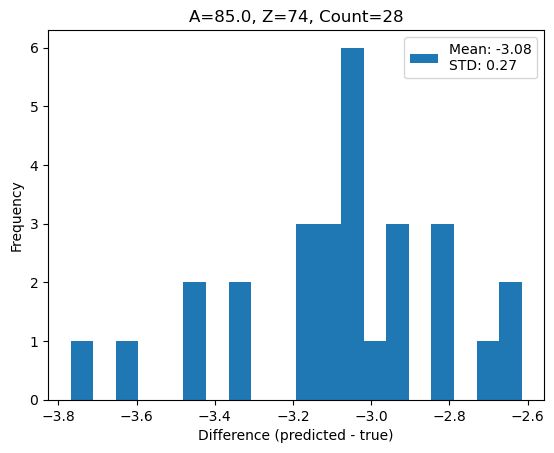

Unique Energy: 83


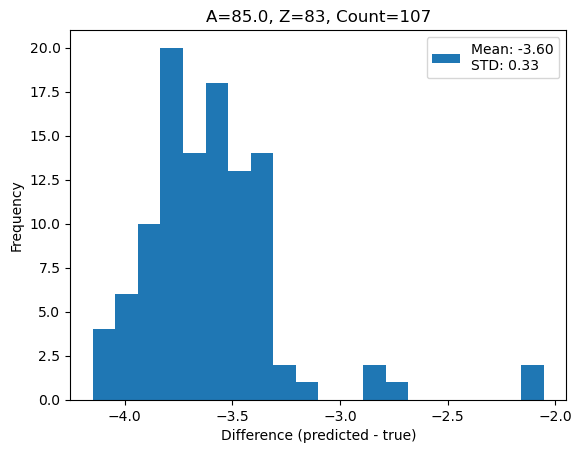

Unique Energy: 91


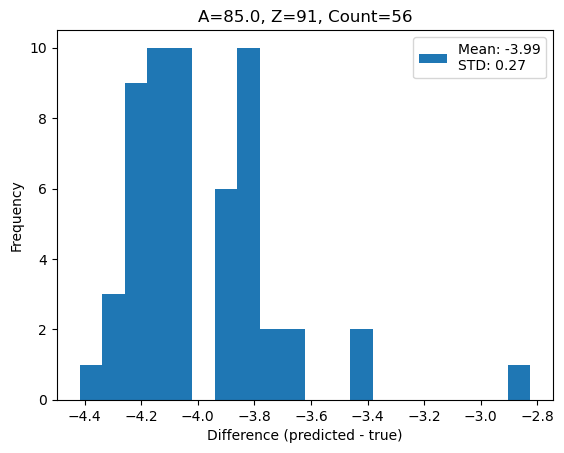

Unique Mass: 90.0
Unique Energy: 106


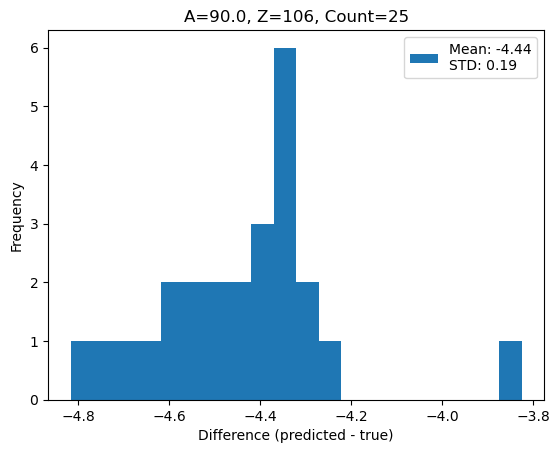

Unique Energy: 52


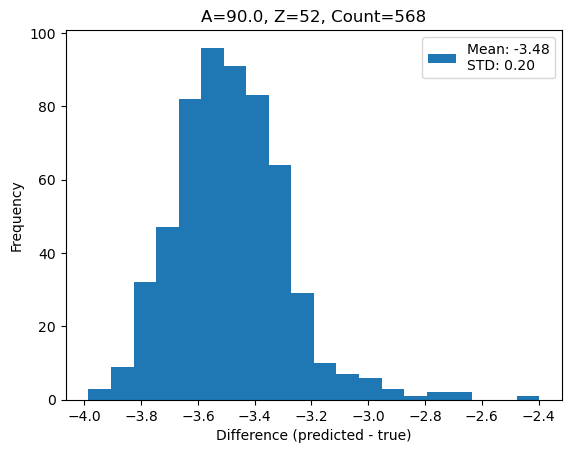

Unique Energy: 61


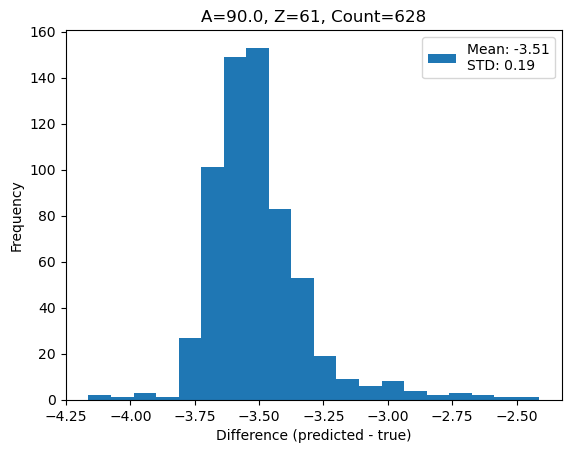

Unique Energy: 70


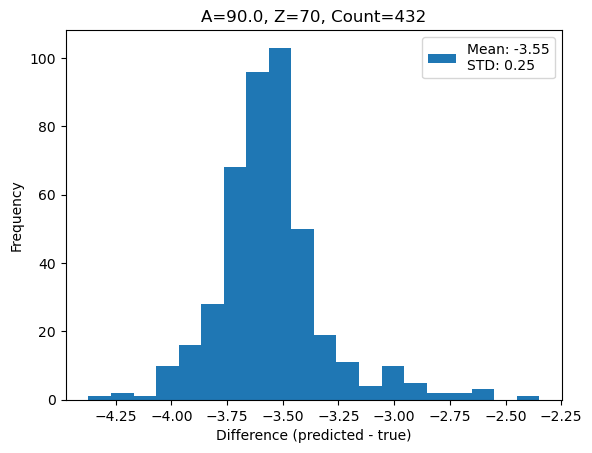

Unique Energy: 79


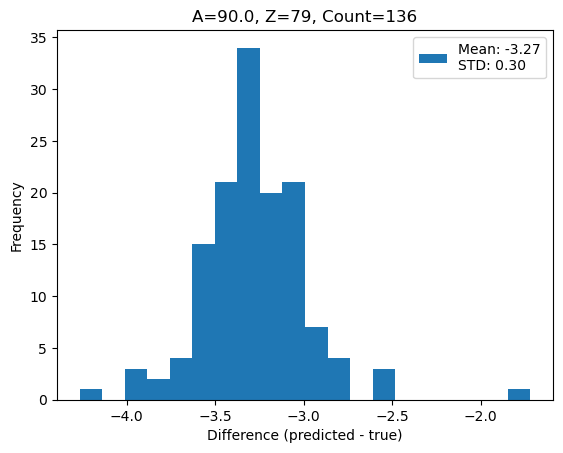

Unique Energy: 88


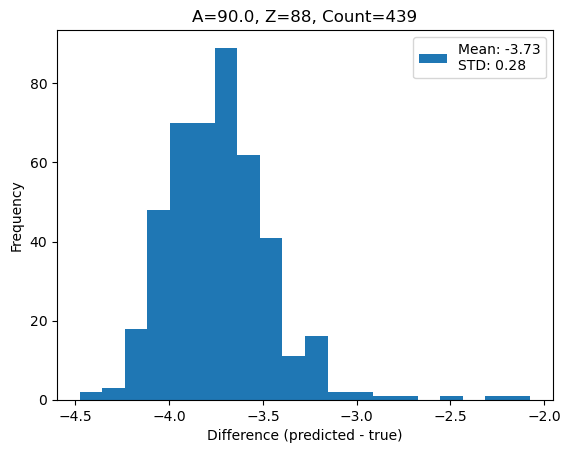

Unique Energy: 97


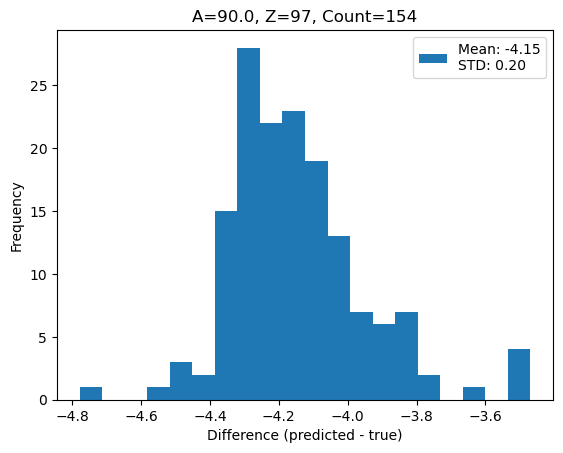

Unique Mass: 91.0
Unique Energy: 19


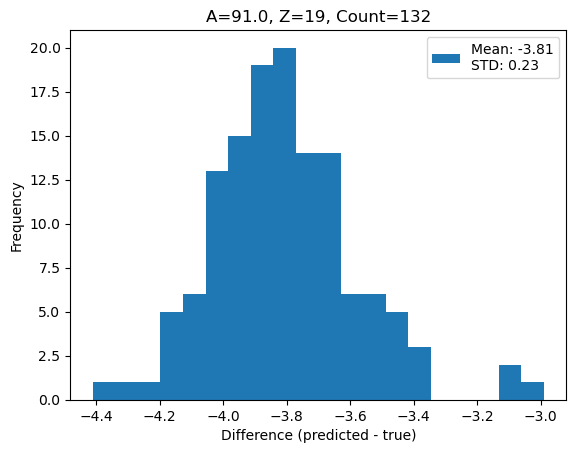

Unique Energy: 26


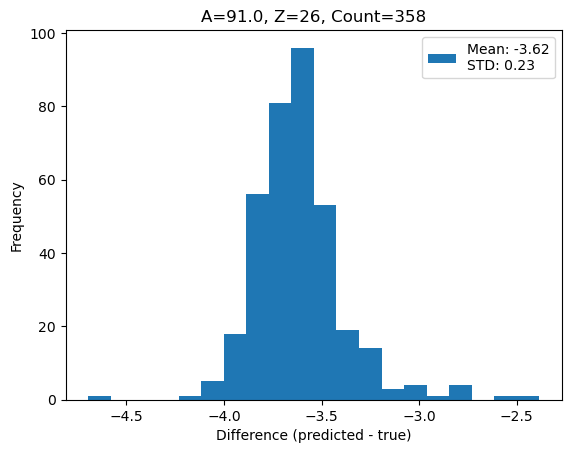

Unique Energy: 33


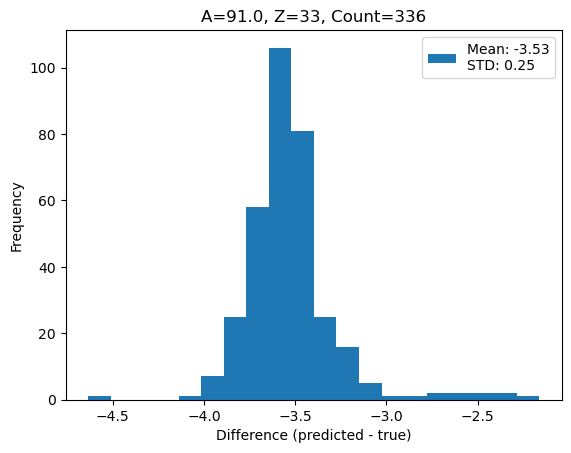

Unique Energy: 40


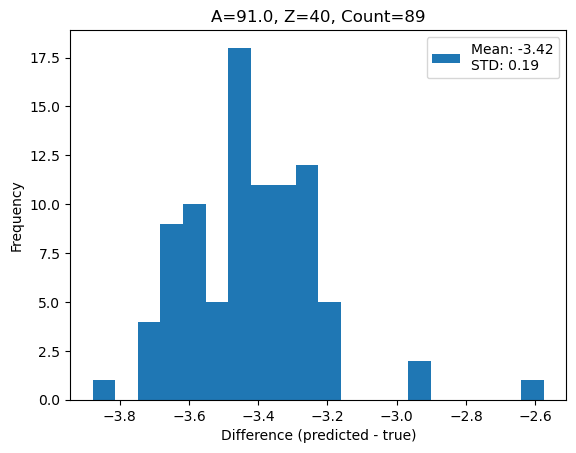

Unique Energy: 47


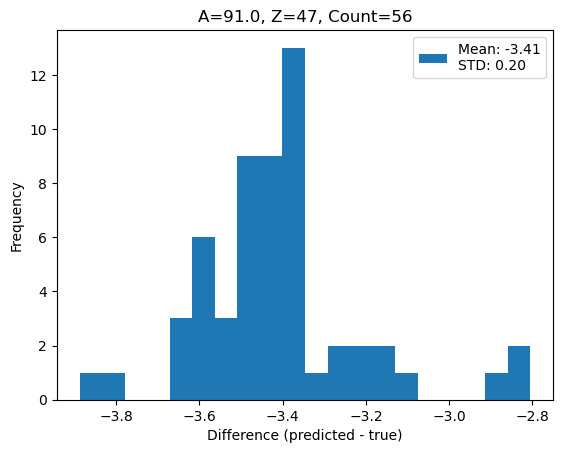

Unique Energy: 54


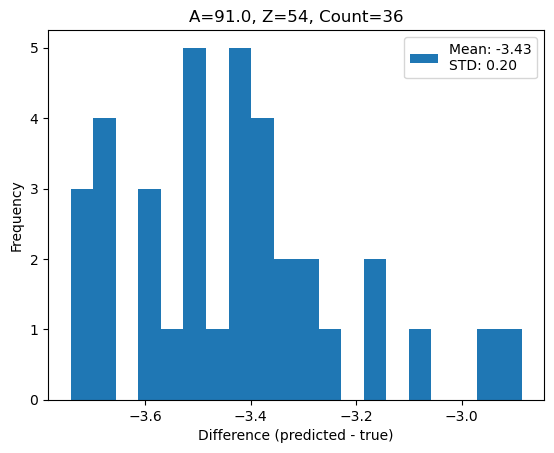

Unique Mass: 95.0
Unique Energy: 102


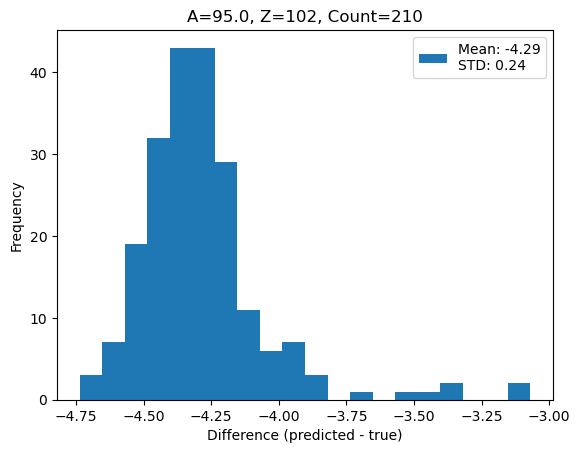

Unique Energy: 55


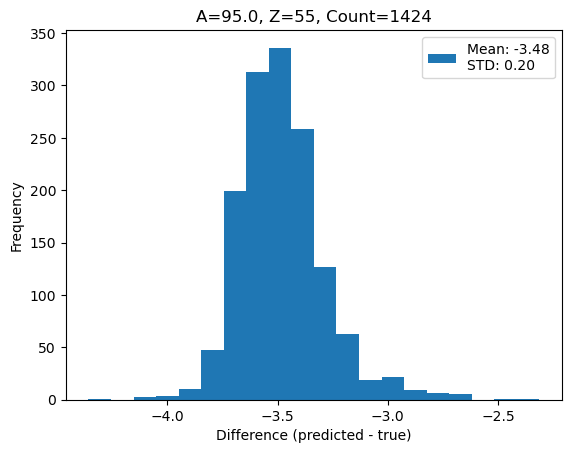

Unique Energy: 64


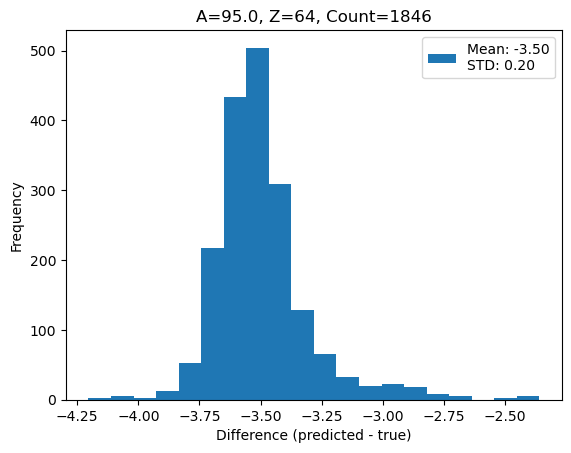

Unique Energy: 74


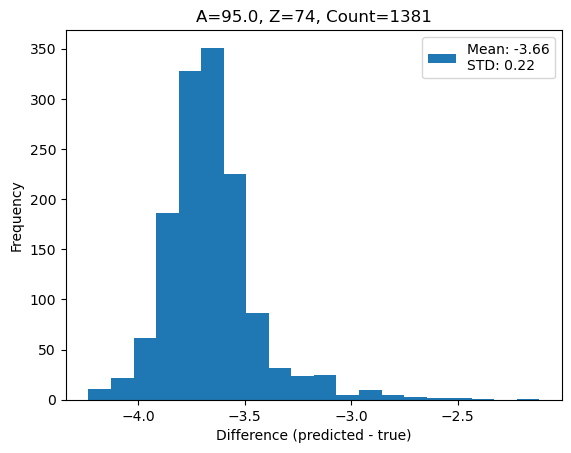

Unique Energy: 83


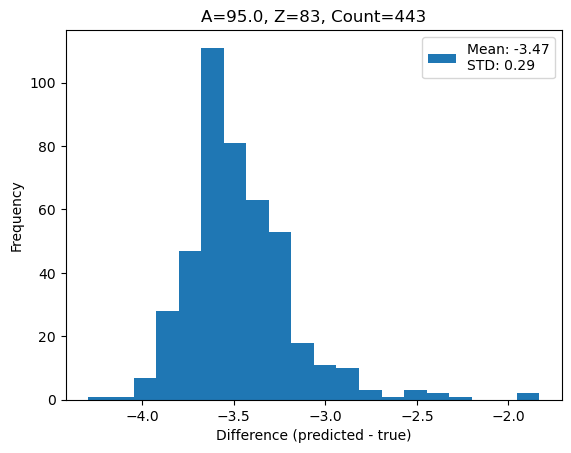

Unique Energy: 93


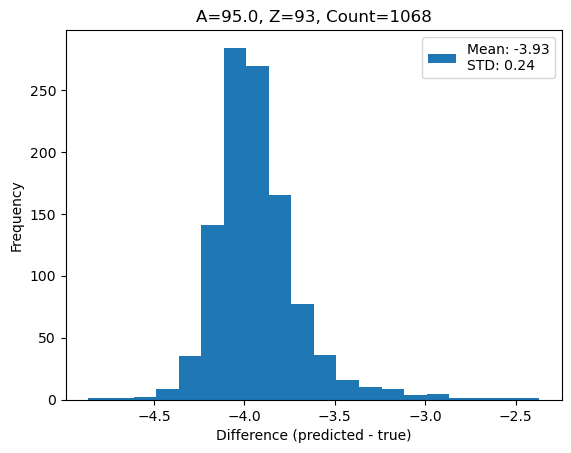

Unique Mass: 97.0
Unique Energy: 27


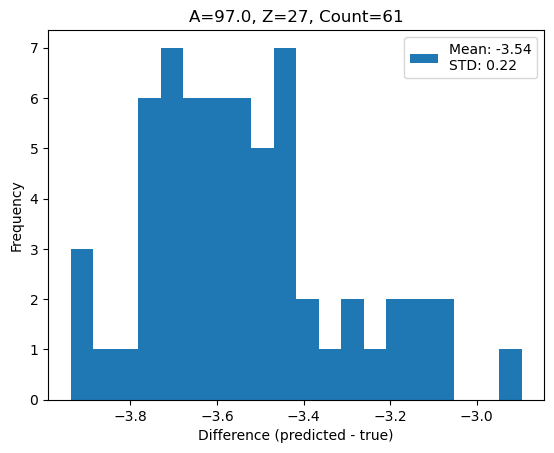

Unique Energy: 34


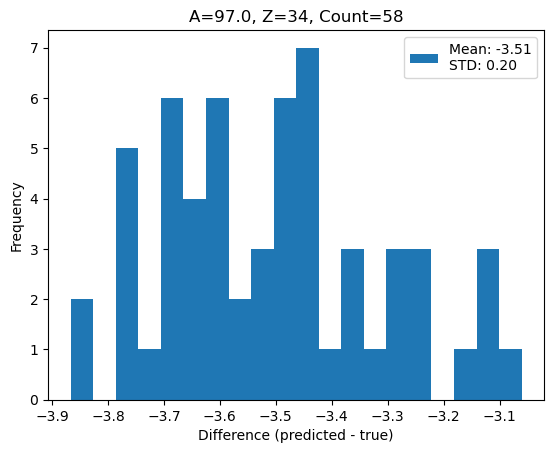

Unique Energy: 41


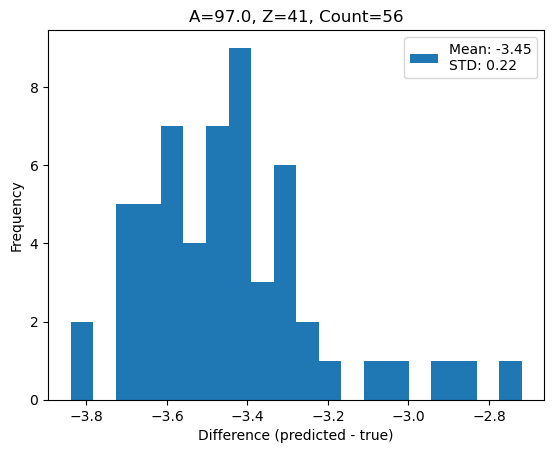

Unique Energy: 48


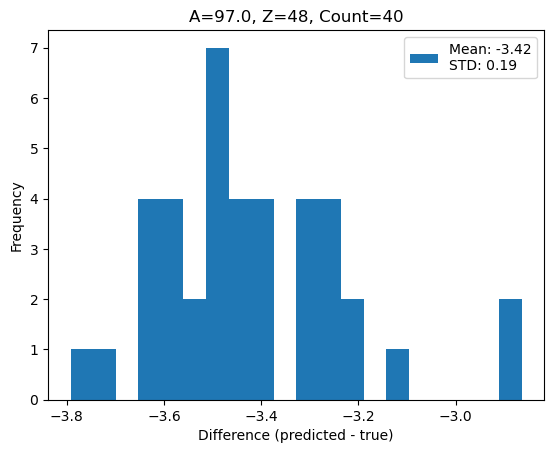

Unique Energy: 55


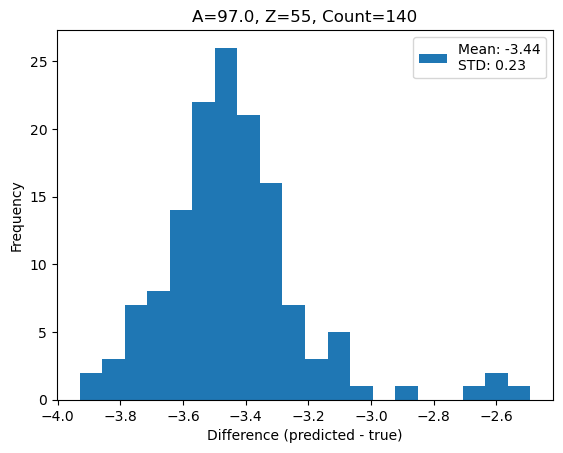

Unique Mass: 100.0, Unique Energy: 107
Avg Test Loss: 4.473298782462247
Count: 71
Mean Test Loss: -4.473298782462247
Standard Deviation Test Loss: 0.176210074427217

Unique Mass: 100.0, Unique Energy: 34
Avg Test Loss: 3.5476320483571313
Count: 607
Mean Test Loss: -3.5476320483571313
Standard Deviation Test Loss: 0.19583587448543488

Unique Mass: 100.0, Unique Energy: 41
Avg Test Loss: 3.4389200449492057
Count: 538
Mean Test Loss: -3.4389200449492057
Standard Deviation Test Loss: 0.19602630561467185

Unique Mass: 100.0, Unique Energy: 48
Avg Test Loss: 3.387103450267194
Count: 432
Mean Test Loss: -3.387103450267194
Standard Deviation Test Loss: 0.22985523242033284

Unique Mass: 100.0, Unique Energy: 58
Avg Test Loss: 3.489671790927646
Count: 1965
Mean Test Loss: -3.489671790927646
Standard Deviation Test Loss: 0.20340447171237705

Unique Mass: 100.0, Unique Energy: 68
Avg Test Loss: 3.4986597993383097
Count: 2650
Mean Test Loss: -3.4986597993383097
Standard Deviation Test Loss: 0.18613

In [17]:
df_test = pd.concat([pd.read_hdf(section_list[i], key=None) for i in range(len(section_list)-5)])
unique_mass_test = df_test['A'].unique()

result_dict = {}  # Dictionary to store unique_mass and corresponding avg_test_loss values

# Test Set
for mass_test in unique_mass_test:
    print(f"Unique Mass: {mass_test}")
    df_intermediate = df_test[df_test['A'] == mass_test]
    unique_energy = df_intermediate['Z'].unique()

    for energy in unique_energy:
        print(f"Unique Energy: {energy}")
        
        df_combination = df_intermediate[df_intermediate['Z'] == energy]

        labels1 = df_combination.iloc[:, 9].values
        labels2 = df_combination['ToF'].values
        labels = labels1 + labels2

        signals = df_combination[df_combination.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]

        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)
        true = labels

        difference = predicted - true

        # Plotting the distribution
        plt.figure()
        plt.hist(difference, bins=20)
        plt.title(f"A={mass_test}, Z={energy}, Count={len(df_combination)}")
        plt.xlabel("Difference (predicted - true)")
        plt.ylabel("Frequency")

        # Calculate mean and standard deviation
        mean = np.mean(difference)
        std = np.std(difference)

        # Create legend text with mean and standard deviation
        legend_text = f"Mean: {mean:.2f}\nSTD: {std:.2f}"

        # Add legend with the mean and standard deviation
        plt.legend([legend_text])

        plt.show()

        avg_test_loss = np.mean(np.abs(difference))
        count = len(df_combination)

        result_dict[(mass_test, energy)] = {
            'avg_test_loss': avg_test_loss,
            'count': count,
            'mean_test_loss': mean,
            'std_test_loss': std
        }

# Print the result dictionary
for (mass, energy), result in result_dict.items():
    avg_test_loss = result['avg_test_loss']
    count = result['count']
    mean_test_loss = result['mean_test_loss']
    std_test_loss = result['std_test_loss']

    print(f"Unique Mass: {mass}, Unique Energy: {energy}")
    print(f"Avg Test Loss: {avg_test_loss}")
    print(f"Count: {count}")
    print(f"Mean Test Loss: {mean_test_loss}")
    print(f"Standard Deviation Test Loss: {std_test_loss}")
    print()

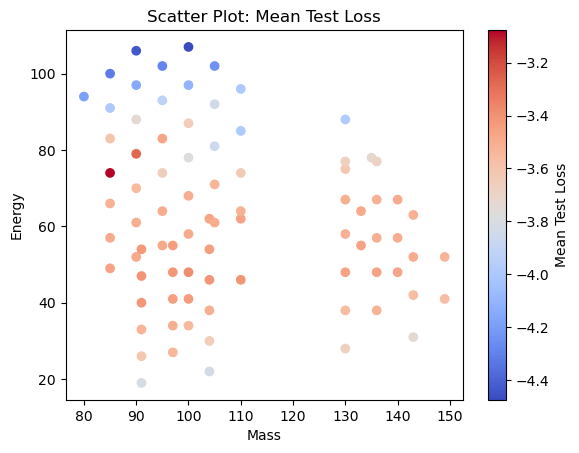

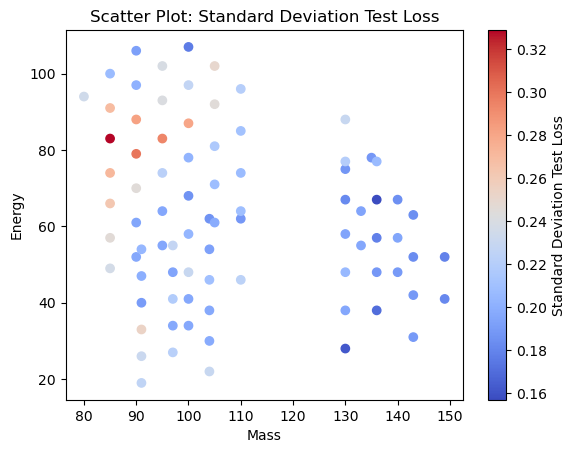

In [18]:
# Extract the data for scatter plots
mass_list = []
energy_list = []
mean_loss_list = []
std_loss_list = []

for (mass, energy), result in result_dict.items():
    mass_list.append(mass)
    energy_list.append(energy)
    mean_loss_list.append(result['mean_test_loss'])
    std_loss_list.append(result['std_test_loss'])

    # Scatter plot for Mean Test Loss
plt.figure()
plt.scatter(mass_list, energy_list, c=mean_loss_list, cmap='coolwarm')
plt.colorbar(label='Mean Test Loss')
plt.xlabel('Mass')
plt.ylabel('Energy')
plt.title('Scatter Plot: Mean Test Loss')
plt.show()

# Scatter plot for Standard Deviation
plt.figure()
plt.scatter(mass_list, energy_list, c=std_loss_list, cmap='coolwarm')
plt.colorbar(label='Standard Deviation Test Loss')
plt.xlabel('Mass')
plt.ylabel('Energy')
plt.title('Scatter Plot: Standard Deviation Test Loss')
plt.show()


NameError: name 'sc2' is not defined

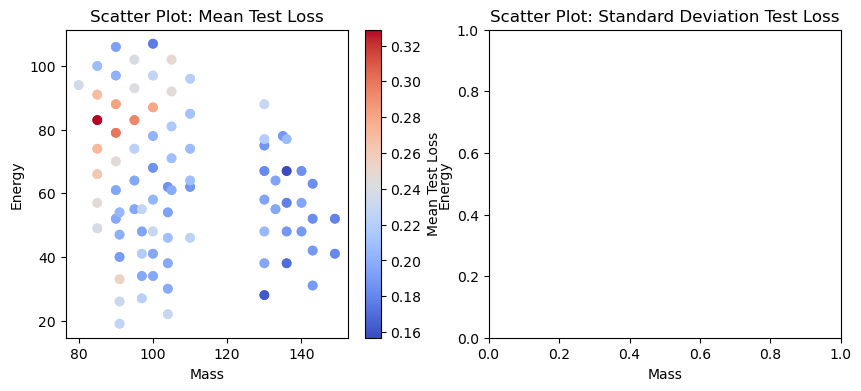

In [20]:

# Extract the data for scatter plots
mass_list = []
energy_list = []
mean_loss_list = []
std_loss_list = []

for (mass, energy), result in result_dict.items():
    mass_list.append(mass)
    energy_list.append(energy)
    mean_loss_list.append(result['mean_test_loss'])
    std_loss_list.append(result['std_test_loss'])

# Scatter plot for Mean Test Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot for Mean Test Loss
# sc1 = ax1.scatter(mass_list, energy_list, c=mean_loss_list, cmap='coolwarm',
#                            norm=colors.LogNorm())
sc1 = ax1.scatter(mass_list, energy_list, c=std_loss_list, cmap='coolwarm')

ax1.set_xlabel('Mass')
ax1.set_ylabel('Energy')
ax1.set_title('Scatter Plot: Mean Test Loss')
fig.colorbar(sc1, ax=ax1, label='Mean Test Loss')

# Scatter plot for Standard Deviation
# sc2 = ax2.scatter(mass_list, energy_list, c=std_loss_list, cmap='coolwarm',
#                           norm=colors.LogNorm())
sc1 = ax1.scatter(mass_list, energy_list, c=std_loss_list, cmap='coolwarm')

ax2.set_xlabel('Mass')
ax2.set_ylabel('Energy')
ax2.set_title('Scatter Plot: Standard Deviation Test Loss')
fig.colorbar(sc2, ax=ax2, label='Standard Deviation Test Loss')

plt.tight_layout()
plt.show()

In [ ]:
df_test = pd.concat([pd.read_hdf(section_list[i], key=None) for i in range(len(section_list))])
unique_mass_test = df_test['A'].unique()

# Test Set
for mass_test in unique_mass_test:
    result_list = []  # List to store results as rows

    df_intermediate = df_test[df_test['A'] == mass_test]
    unique_energy = df_intermediate['Z'].unique()

    for energy in unique_energy:
        df_combination = df_intermediate[df_intermediate['Z'] == energy]

        labels1 = df_combination.iloc[:, 9].values
        labels2 = df_combination['ToF'].values
        labels = labels1 + labels2

        signals = df_combination[df_combination.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]

        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)
        true = labels

        difference = predicted - true
        # Calculate mean and standard deviation
        mean = np.mean(difference)
        std = np.std(difference)

        avg_test_loss = np.mean(np.abs(difference))
        count = len(df_combination)

        result_list.append([round(mass_test), round(energy), avg_test_loss, count, mean, std])

    # Create the tabular representation for the current unique mass
    headers = ["Unique Mass", "Unique Energy", "Avg Test Loss", "Count", "Mean Test Loss", "Std Test Loss"]
    tabular_result = tabulate(result_list, headers=headers, floatfmt=".3f", tablefmt="github")

    # Print the tabular result for the current unique mass
    print(f"Tabular representation for Unique Mass: {mass_test}")
    print(tabular_result)
    print()

In [ ]:
# Group the data by unique mass and energy
grouped_data = df_test.groupby(['A'])

# Create an empty list to store the energies for each unique mass
energies_per_mass = []

# Iterate over each unique mass group
for mass, group in grouped_data:
    energies = group['Z'].unique()  # Get the unique energies for the current mass
    energies_per_mass.append((mass, energies))  # Append the unique mass and energies tuple to the list

# Create a list to store the average test losses for each unique mass
avg_test_losses = []

# Create an empty list to store the differences for each unique mass
differences_per_mass = []

# Iterate over the unique masses
for i, (mass, energies) in enumerate(energies_per_mass, 1):
    # Create a list to store the differences for the current mass
    differences = []

    # Iterate over the energies for the current mass
    for energy in energies:
        # Retrieve the data for the current mass and energy
        data = df_test[(df_test['A'] == mass) & (df_test['Z'] == energy)]
        
        # Extract the features (signals) and labels (true values)
        signals = data[data.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]
        labels1 = data.iloc[:, 9].values
        labels2 = data['ToF'].values
        labels = labels1 + labels2

        # Predict the labels using the model
        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)

        # Calculate the difference between predicted and true labels
        difference = predicted - labels
        differences.append(difference)  # Store the difference for the current energy

    differences_per_mass.append(differences)  # Store the differences for the current mass

    # Calculate the average test loss for the current mass
    avg_test_loss = np.mean(np.abs(np.concatenate(differences)))  # Concatenate the differences for all energies
    avg_test_losses.append(avg_test_loss)  # Store the average test loss

# Iterate over the unique masses and corresponding differences
for i, (mass, differences) in enumerate(zip(energies_per_mass, differences_per_mass), 1):
    energies = mass[1]  # Get the energies for the current mass

    # Sort the energies in ascending order
    sorted_energies = np.sort(energies)

    # Get the indices to reorder the differences based on the sorted energies
    indices = np.argsort(energies)
    reordered_differences = [differences[index] for index in indices]

    plt.figure(figsize=(150, 6))  # Adjust the figure size as needed
    plt.subplot(1, len(energies_per_mass), i)  # Create a subplot for each unique mass
    plt.boxplot(reordered_differences)
    plt.title(f"Unique Mass: {mass[0]}")
    plt.xlabel("Energy")
    plt.ylabel("Difference (Predicted - True)")

    # Set the x-axis tick labels to the sorted energies
    plt.xticks(range(1, len(sorted_energies) + 1), sorted_energies)

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

# Print the average test losses
for i, (mass, _) in enumerate(energies_per_mass, 1):
    print(f"Unique Mass: {mass}, Average Test Loss: {avg_test_losses[i-1]}")

In [ ]:
# Create a list to store the average test losses for each unique mass
avg_test_losses = []

# Create an empty list to store the differences for each unique mass
differences_per_mass = []

# Iterate over the unique masses
for i, (mass, energies) in enumerate(energies_per_mass, 1):
    # Create a list to store the differences for the current mass
    differences = []

    # Iterate over the energies for the current mass
    for energy in energies:
        # Retrieve the data for the current mass and energy
        data = df_test[(df_test['A'] == mass) & (df_test['Z'] == energy)]
        
        # Extract the features (signals) and labels (true values)
        signals = data[data.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]
        labels1 = data.iloc[:, 9].values
        labels2 = data['ToF'].values
        labels = labels1 + labels2

        # Predict the labels using the model
        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)

        # Calculate the difference between predicted and true labels
        difference = predicted - labels
        differences.append(difference)  # Store the difference for the current energy

    differences_per_mass.append(differences)  # Store the differences for the current mass

    # Calculate the average test loss for the current mass
    avg_test_loss = np.mean(np.abs(np.concatenate(differences)))  # Concatenate the differences for all energies
    avg_test_losses.append(avg_test_loss)  # Store the average test loss

# Iterate over the unique masses and corresponding differences
for i, (mass, differences) in enumerate(zip(energies_per_mass, differences_per_mass), 1):
    energies = mass[1]  # Get the energies for the current mass

    # Sort the energies in ascending order
    sorted_energies = np.sort(energies)

    # Get the indices to reorder the differences based on the sorted energies
    indices = np.argsort(energies)
    reordered_differences = [differences[index] for index in indices]

    plt.figure(figsize=(150, 6))  # Adjust the figure size as needed
    plt.subplot(1, len(energies_per_mass), i)  # Create a subplot for each unique mass
    plt.boxplot(reordered_differences)
    plt.title(f"Unique Mass: {mass[0]}")
    plt.xlabel("Energy")
    plt.ylabel("Difference (Predicted - True)")

    # Set the x-axis tick labels to the sorted energies
    plt.xticks(range(1, len(sorted_energies) + 1), sorted_energies)

    # Add a text box with counts for each energy
    counts = [len(d) for d in reordered_differences]
    text_box = "\n".join([f"E{e}: {count}" for e, count in zip(sorted_energies, counts)])
    plt.text(0.95, 0.95, text_box, transform=plt.gca().transAxes, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

    


In [ ]:
df_test = pd.concat([pd.read_hdf(section_list[i], key=None) for i in range(len(section_list))])
unique_mass_test = df_test['A'].unique()

result_list = []  # List to store results for all unique mass and energy combinations

# Test Set
for mass_test in unique_mass_test:
    df_intermediate = df_test[df_test['A'] == mass_test]
    unique_energy = df_intermediate['Z'].unique()

    for energy in unique_energy:
        df_combination = df_intermediate[df_intermediate['Z'] == energy]

        labels1 = df_combination.iloc[:, 9].values
        labels2 = df_combination['ToF'].values
        labels = labels1 + labels2

        signals = df_combination[df_combination.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]

        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)
        true = labels

        difference = predicted - true

        # Calculate mean and standard deviation
        mean = np.mean(difference)
        std = np.std(difference)

        avg_test_loss = np.mean(np.abs(difference))
        count = len(df_combination)

        result_list.append([mass_test, energy, avg_test_loss, count, mean, std])

# Sort the results by avg_test_loss in ascending order
result_list.sort(key=lambda x: x[2])

# Print the 5 best cases
best_cases = result_list[:5]

for case in best_cases:
    mass_test, energy, avg_test_loss, count, mean, std = case

    # Plotting the distribution
    df_combination = df_test[(df_test['A'] == mass_test) & (df_test['Z'] == energy)]
    labels1 = df_combination.iloc[:, 9].values
    labels2 = df_combination['ToF'].values
    labels = labels1 + labels2

    signals = df_combination[df_combination.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)
    true = labels

    difference = predicted - true

    fig, ax = plt.subplots()
    ax.hist(difference, bins=20)
    ax.set_title(f"Best Case - A={mass_test}, Z={energy}, Count={count}")
    ax.set_xlabel("Data")
    ax.set_ylabel("Difference (predicted - true)")
    ax.text(0.75, 0.9, f"Mean: {mean:.2f}\nSTD: {std:.2f}", transform=ax.transAxes, bbox=dict(facecolor='white'))
    plt.show()

    print(f"Unique Mass: {mass_test}, Unique Energy: {energy}")
    print(f"Avg Test Loss: {avg_test_loss}")
    print(f"Count: {count}")
    print(f"Mean Test Loss: {mean}")
    print(f"Standard Deviation Test Loss: {std}")
    print()

In [ ]:
df_test = pd.concat([pd.read_hdf(section_list[i], key=None) for i in range(len(section_list))])
unique_mass_test = df_test['A'].unique()

result_list = []  # List to store results for all unique mass and energy combinations

# Test Set
for mass_test in unique_mass_test:
    df_intermediate = df_test[df_test['A'] == mass_test]
    unique_energy = df_intermediate['Z'].unique()

    for energy in unique_energy:
        df_combination = df_intermediate[df_intermediate['Z'] == energy]

        labels1 = df_combination.iloc[:, 9].values
        labels2 = df_combination['ToF'].values
        labels = labels1 + labels2

        signals = df_combination[df_combination.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]

        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)
        true = labels

        difference = predicted - true

        # Calculate mean and standard deviation
        mean = np.mean(difference)
        std = np.std(difference)

        avg_test_loss = np.mean(np.abs(difference))
        count = len(df_combination)

        result_list.append([mass_test, energy, avg_test_loss, count, mean, std])

# Sort the results by avg_test_loss in ascending order
result_list.sort(key=lambda x: x[2])

# Print the 5 worst cases
worst_cases = result_list[-5:]

for case in worst_cases:
    mass_test, energy, avg_test_loss, count, mean, std = case

    # Plotting the distribution
    df_combination = df_test[(df_test['A'] == mass_test) & (df_test['Z'] == energy)]
    labels1 = df_combination.iloc[:, 9].values
    labels2 = df_combination['ToF'].values
    labels = labels1 + labels2

    signals = df_combination[df_combination.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)
    true = labels

    difference = predicted - true

    fig, ax = plt.subplots()
    ax.hist(difference, bins=20)
    ax.set_title(f"Worst Case - A={mass_test}, Z={energy}, Count={count}")
    ax.set_xlabel("Data")
    ax.set_ylabel("Difference (predicted - true)")
    ax.text(0.75, 0.9, f"Mean: {mean:.2f}\nSTD: {std:.2f}", transform=ax.transAxes, bbox=dict(facecolor='white'))
    plt.show()

    print(f"Unique Mass: {mass_test}, Unique Energy: {energy}")
    print(f"Avg Test Loss: {avg_test_loss}")
    print(f"Count: {count}")
    print(f"Mean Test Loss: {mean}")
    print(f"Standard Deviation Test Loss: {std}")
    print()